# Setup Basic Tools
## Import Modules

In [1]:
import os
import sys
import csv, json
import math, random, ast, swifter
import warnings
import numpy as np
import pandas as pd
import datetime as dt
import portion as P
import itertools as it
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from pprint import pprint
from collections import namedtuple

# Configure display options
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
%config InlineBackend.figure_format = 'retina'

# Set plot style
# plt.style.use('ggplot')

## Function: unify data format

In [2]:
def set_data(df, mode='pcap', tz=0):
    def nr_serv_cel(row):
        pos = row.serv_cel_pos
        if pos == 255:
            return 65535, -160, -50
        else:
            return row[f'PCI{pos}'], row[f'RSRP{pos}'], row[f'RSRQ{pos}']
    
    if mode == 'pcap':
        common_column_names = ['seq', 'rpkg', 'frame_id', 'Timestamp', 'lost', 'excl', 'latency', 'xmit_time', 'arr_time']
        
        if df.empty:
            return pd.DataFrame(columns=common_column_names)
        
        date_columns = ['Timestamp', 'xmit_time', 'arr_time']
        df[date_columns] = df[date_columns].apply(pd.to_datetime)
        df[['seq', 'rpkg', 'frame_id']] = df[['seq', 'rpkg', 'frame_id']].astype('Int32')
        df[['latency']] = df[['latency']].astype('float32')
        df[['lost', 'excl']] = df[['lost', 'excl']].astype('boolean')

    if mode in ['lte', 'nr']:
        common_column_names = [
            'Timestamp', 'type_id', 'PCI', 'RSRP', 'RSRQ', 'serv_cel_index', 'EARFCN', 'NR_ARFCN', 
            'num_cels', 'num_neigh_cels', 'serv_cel_pos', 'PCI0', 'RSRP0', 'RSRQ0',
        ]
        
        if df.empty:
            return pd.DataFrame(columns=common_column_names)
        
        if mode == 'lte':
            columns_mapping = {
                'RSRP(dBm)': 'RSRP',
                'RSRQ(dB)': 'RSRQ',
                'Serving Cell Index': 'serv_cel_index',
                'Number of Neighbor Cells': 'num_neigh_cels',
                'Number of Detected Cells': 'num_cels',
            }
            columns_order = [*common_column_names, *df.columns[df.columns.get_loc('PCI1'):].tolist()]
            
            df = df.rename(columns=columns_mapping).reindex(columns_order, axis=1)
            df['serv_cel_index'] = np.where(df['serv_cel_index'] == '(MI)Unknown', '3_SCell', df['serv_cel_index'])
            df['num_cels'] = df['num_neigh_cels'] + 1
            df['type_id'] = 'LTE_PHY'

        if mode == 'nr':
            columns_mapping = {
                'Raster ARFCN': 'NR_ARFCN',
                'Serving Cell Index': 'serv_cel_pos',
                'Num Cells': 'num_cels',
            }
            columns_order = [*common_column_names, *df.columns[df.columns.get_loc('PCI1'):].tolist()]
            
            df = df.rename(columns=columns_mapping).reindex(columns_order, axis=1)
            df[['PCI', 'RSRP', 'RSRQ']] = df.apply(nr_serv_cel, axis=1, result_type='expand')
            df['serv_cel_index'] = np.where(df['serv_cel_pos'] == 255, df['serv_cel_index'], 'PSCell')
            df['num_neigh_cels'] = np.where(df['serv_cel_pos'] == 255, df['num_cels'], df['num_cels'] - 1)
            df['type_id'] = '5G_NR_ML1'
        
        df['Timestamp'] = pd.to_datetime(df['Timestamp']) + pd.Timedelta(hours=tz)
        df[['type_id', 'serv_cel_index']] = df[['type_id', 'serv_cel_index']].astype('category')
        df[['EARFCN', 'NR_ARFCN']] = df[['EARFCN', 'NR_ARFCN']].astype('Int32')
        df[['num_cels', 'num_neigh_cels', 'serv_cel_pos']] = df[['num_cels', 'num_neigh_cels', 'serv_cel_pos']].astype('UInt8')

        for tag in df.columns:
            if tag.startswith('PCI'):
                df[tag] = df[tag].astype('Int32')
            if tag.startswith(('RSRP', 'RSRQ')):
                df[tag] = df[tag].astype('float32')

    return df



## Function: parse handover event
### Stage 1: rrc to handover dictionary

- Sheng-Ru latest version (2023-09-25)
    - 2023-10-27: add try ... except ... statement
    - 2023-11-13: add NR ARFCN

In [3]:
triggered_events = {
    'HO':     ['LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM', 'SCGA', 'SCGR-I', 'SCGC-I', 'SCGR-II', 'SCGC-II', ],
    'RLF':    ['MCGF', 'NASR', 'SCGF', ],
    'Others': ['CXNS', 'CXNR', 'SCLA', ],
}

rlf_events = {
    'MCGF': ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)', ],
    'NASR': ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)', ],
    'SCGF': ['t310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)', ],
}

In [4]:
def parse_mi_ho(df, tz=8):

    # df = pd.read_csv(f)
    df["Timestamp"] = df["Timestamp"].swifter.apply(lambda x: pd.to_datetime(x) + dt.timedelta(hours=tz))
    nr_pci = 'O'
    nr_arfcn = 0
    scells = []

    def NR_OTA(idx):

        if df["type_id"].iloc[idx] == "5G_NR_RRC_OTA_Packet": return True
        else: return False
    
    def LTE_SERV_INFO(idx):

        if df["type_id"].iloc[idx] == "LTE_RRC_Serv_Cell_Info": return True
        else: return False
    

    def find_1st_after(start_idx, target, look_after=1):
        for j in range(start_idx, len(df)):
            t_ = df["Timestamp"].iloc[j]
            if NR_OTA(j) or LTE_SERV_INFO(j):
                continue
            if (t_ - t).total_seconds() > look_after:
                return None, None
            if df[target].iloc[j] not in [0,'0'] and not np.isnan(df[target].iloc[j]):
                return t_, j
        return None, None
    
    def find_1st_before(start_idx, target, look_before=1):
        for j in range(start_idx, -1, -1):
            t_ = df["Timestamp"].iloc[j]
            if NR_OTA(j) or LTE_SERV_INFO(j):
                continue
            if (t - t_).total_seconds() > look_before:
                return None, None
            if df[target].iloc[j] not in [0,'0'] and not np.isnan(df[target].iloc[j]):
                return t_, j
        return None, None
    
    def find_1st_before_with_special_value(start_idx, target, target_value, look_before=1):
        for j in range(start_idx, -1, -1):
            t_ = df["Timestamp"].iloc[j]
            if NR_OTA(j) or LTE_SERV_INFO(j):
                continue
            if (t - t_).total_seconds() > look_before:
                return None, None
            if df[target].iloc[j] in [target_value] and not np.isnan(df[target].iloc[j]):
                return t_, j
        return None, None
    
    def find_in_D_exact(targets):

        l = []
        # In l : (second, ho_type)
        for target in targets:
            for ho in D[target]:
                l.append(((t - ho.start).total_seconds(), target))

        if len(l) != 0:
            for x in l:
                if (x[0]== 0):
                    return x[1]
        
        return None
    
    def find_in_D_first_before(targets, look_before=1):

        l = []
        # In l : (second, ho_type)
        for target in targets:
            for ho in D[target]:
                try:
                    l.append(((t - ho.end).total_seconds(), target, ho))
                except:
                    pass

        if len(l) != 0:
            closest = min(filter(lambda x: x[0] > 0, l), key=lambda x: x[0])
            if 0 <= closest[0] < look_before:
                return closest[1], closest[2]
        
        return None, None
    
    HO = namedtuple('HO',['start', 'end', 'others', 'trans'], defaults=[None,None,'',''])
    
    D = {
        'Conn_Rel':[], 
        'Conn_Req':[], # Setup
        'LTE_HO': [], # LTE -> newLTE
        'MN_HO': [], # LTE + NR -> newLTE + NR
        'MN_HO_to_eNB': [], # LTE + NR -> newLTE
        'SN_setup': [], # LTE -> LTE + NR => NR setup
        'SN_Rel': [], # LTE + NR -> LTE
        'SN_HO': [], # LTE + NR -> LTE + newNR  
        'RLF_II': [],
        'RLF_III': [],
        'SCG_RLF': [],
        'Add_SCell': [],
        }

    for i in range(len(df)):

        # Pass NR RRC packet. In NSA mode, LTE RRC packet include NR packet message.
        if NR_OTA(i) or LTE_SERV_INFO(i):
            continue

        others = ''
        t = df["Timestamp"].iloc[i]

        if df["rrcConnectionRelease"].iloc[i] == 1:
            D['Conn_Rel'].append(HO(start=t))
            nr_pci = 'O'

        if df["rrcConnectionRequest"].iloc[i] == 1:
            
            # Define end of rrcConnectionRequest to be rrcConnectionReconfigurationComplete or securityModeComplete.
            a = find_1st_after(i, 'rrcConnectionReconfigurationComplete',look_after=2)[0]
            b = find_1st_after(i, 'securityModeComplete',look_after=2)[0]
            if a is None and b is None: end = None
            elif a is None and b is not None: end = b
            elif a is not None and b is None: end = a 
            else: end = a if a > b else b
            
            serv_cell, serv_freq = df["PCI"].iloc[i], int(df["Freq"].iloc[i])
            trans = f'? -> ({serv_cell}, {serv_freq})'
            D['Conn_Req'].append(HO(start=t,end=end,trans=trans))
            nr_pci = 'O'
        
        if df["lte-rrc.t304"].iloc[i] == 1:
            
            end, _ = find_1st_after(i, 'rrcConnectionReconfigurationComplete')
            serv_cell, target_cell = df["PCI"].iloc[i], int(df['lte_targetPhysCellId'].iloc[i])
            serv_freq, target_freq = int(df["Freq"].iloc[i]), int(df['dl-CarrierFreq'].iloc[i])

            if df["SCellToAddMod-r10"].iloc[i] == 1:
                n =len(str(df["SCellIndex-r10.1"].iloc[i]).split('@'))
                others += f' Set up {n} SCell.'
            else:
                scells = []
            
            if serv_freq != target_freq:
                a,b = find_1st_before(i, "rrcConnectionReestablishmentRequest", 1)
                others += " Inter frequency HO."
                if a is not None:
                    others += " Near after RLF."
                
            if df["nr-rrc.t304"].iloc[i] == 1 and df["dualConnectivityPHR: setup (1)"].iloc[i] == 1:
                
                if serv_cell == target_cell and serv_freq == target_freq:

                    a, _ = find_1st_before(i, "rrcConnectionReestablishmentRequest", 2)
                    
                    if a is not None:

                        ho_type, ho = find_in_D_first_before(['RLF_II', 'RLF_III'], 2)
                        try:
                            others += f' Near after RLF of trans: {ho.trans}.'
                        except:
                            others += f' Near after RLF.'

                    else:
                        
                        ho_type, _ = find_in_D_first_before(['MN_HO_to_eNB', 'SN_Rel'], 2)
                        if ho_type is not None:
                            others += f' Near after {ho_type}.'
                    orig_serv = (nr_pci, nr_arfcn) if nr_pci != 'O' else 'O'
                    nr_pci = int(df['nr_physCellId'].iloc[i])
                    nr_arfcn = int(df['absoluteFrequencySSB'].iloc[i])
                    trans = f'({serv_cell}, {serv_freq}) | {orig_serv} -> ({nr_pci}, {nr_arfcn})'
                    D['SN_setup'].append(HO(start=t, end=end, others=others, trans=trans))

                else:
                    
                    nr_pci = int(df['nr_physCellId'].iloc[i])
                    trans = f'({serv_cell}, {serv_freq}) -> ({target_cell}, {target_freq}) | ({nr_pci}, {nr_arfcn})'
                    D['MN_HO'].append(HO(start=t, end=end, others=others, trans=trans))

            else:
                
                if serv_cell == target_cell and serv_freq == target_freq:

                    a, b = find_1st_before(i, "scgFailureInformationNR-r15")
                    if a is not None:
                        others += " Caused by scg-failure."
                    
                    orig_serv = (nr_pci, nr_arfcn) if nr_pci != 'O' else 'O'
                    nr_pci = 'O'
                    trans = f'({serv_cell}, {serv_freq}) | {orig_serv} -> {nr_pci}'
                    D['SN_Rel'].append(HO(start=t, end=end, others=others, trans=trans))
                    
                else:

                    a, _ = find_1st_before(i,"rrcConnectionSetup",3)
                    if a is not None:
                        others += ' Near After connection setup.'
                    if nr_pci == 'O':
                        trans = f'({serv_cell}, {serv_freq}) -> ({target_cell}, {target_freq}) | {nr_pci}'
                        D['LTE_HO'].append(HO(start=t, end=end, others=others, trans=trans))
                    else:
                        orig_serv = (nr_pci, nr_arfcn) if nr_pci != 'O' else 'O'
                        nr_pci = 'O'
                        trans = f'({serv_cell}, {serv_freq}) -> ({target_cell}, {target_freq}) | {orig_serv} -> {nr_pci}'
                        D['MN_HO_to_eNB'].append(HO(start=t, end=end, others=others, trans=trans))


        if df["nr-rrc.t304"].iloc[i] == 1 and not df["dualConnectivityPHR: setup (1)"].iloc[i] == 1:

            end, _ = find_1st_after(i,'rrcConnectionReconfigurationComplete')
        
            serv_cell, serv_freq = df["PCI"].iloc[i], int(df["Freq"].iloc[i])
            orig_serv = (nr_pci, nr_arfcn) if nr_pci != 'O' else 'O'
            nr_pci = int(df['nr_physCellId'].iloc[i])
            nr_arfcn = int(df['absoluteFrequencySSB'].iloc[i])
            trans = f'({serv_cell}, {serv_freq}) | {orig_serv} -> ({nr_pci}, {nr_arfcn})'
            D['SN_HO'].append(HO(start=t,end=end,trans=trans))


        if df["rrcConnectionReestablishmentRequest"].iloc[i] == 1:

            end1, _ = find_1st_after(i, 'rrcConnectionReestablishmentComplete', look_after=1)
            b, _ = find_1st_after(i, 'rrcConnectionReestablishmentReject', look_after=1)
            end2, _ = find_1st_after(i, 'securityModeComplete',look_after=3)

            others += ' ' + df["reestablishmentCause"].iloc[i] + '.'
            scells = []

            c, _ = find_1st_before(i, 'scgFailureInformationNR-r15', 1)
            if c != None:
                others  += ' caused by scgfailure.'
                
            serv_cell, rlf_cell = df["PCI"].iloc[i], int(df['physCellId.3'].iloc[i])
            serv_freq = int(df['Freq'].iloc[i])
            
            # Type II & Type III
            if end1 is not None: 

                orig_serv = (nr_pci, nr_arfcn) if nr_pci != 'O' else 'O'
                nr_pci = 'O'
                _, idx = find_1st_before_with_special_value(i, 'PCI', rlf_cell, look_before=10)
                try:
                    rlf_freq = int(df['Freq'].iloc[idx])
                except:
                    rlf_freq = 0
                trans = f'({rlf_cell}, {rlf_freq}) -> ({serv_cell}, {serv_freq}) | {orig_serv} -> {nr_pci}'
                D['RLF_II'].append(HO(start=t,end=end1,others=others,trans=trans))

            elif b is not None and end2 is not None:
                
                orig_serv = (nr_pci, nr_arfcn) if nr_pci != 'O' else 'O'
                nr_pci = 'O'
                _, idx = find_1st_before_with_special_value(i, 'PCI', rlf_cell, look_before=10)
                try:
                    rlf_freq = int(df['Freq'].iloc[idx])
                except:
                    rlf_freq = 0

                _, idx = find_1st_after(i, "rrcConnectionRequest", 2)
                recon_cell, recon_freq = df['PCI'].iloc[idx], int(float(df['Freq'].iloc[idx]))
                
                trans = f'({rlf_cell}, {rlf_freq}) -> ({recon_cell}, {recon_freq}) | {orig_serv} -> {nr_pci}'
                D['RLF_III'].append(HO(start=t,end=end2,others=others,trans=trans))
                
            else:
                others+=' No end.'
                D['RLF_II'].append(HO(start=t,others=others))
                print('No end for RLF')

        if df["scgFailureInformationNR-r15"].iloc[i] == 1:

            others += ' ' + df["failureType-r15"].iloc[i] + '.'
            a, idx1 = find_1st_after(i, "rrcConnectionReestablishmentRequest", look_after=1)
            b, idx2 = find_1st_after(i, "lte-rrc.t304", look_after=10)

            if a is not None:

                end1, _ = find_1st_after(idx1, 'rrcConnectionReestablishmentComplete', look_after=1)
                b, _ = find_1st_after(idx1, 'rrcConnectionReestablishmentReject', look_after=1)
                end2 = find_1st_after(idx1, 'securityModeComplete',look_after=3)[0]

                others += ' Result in rrcReestablishment.'
                    
                # Type II & Type III Result
                if end1 is not None: 
                    D['SCG_RLF'].append(HO(start=t,end=end1,others=others))
                elif b is not None and end2 is not None: 
                    D['SCG_RLF'].append(HO(start=t,end=end2,others=others))
                else:
                    others += ' No end.'
                    D['SCG_RLF'].append(HO(start=t,others=others))
                    print('No end for scg failure result in rrcReestablishment.')

            elif b is not None:

                end, _ = find_1st_after(idx2, 'rrcConnectionReconfigurationComplete')
                serv_cell, target_cell = df["PCI"].iloc[idx2], df['lte_targetPhysCellId'].iloc[idx2]
                serv_freq, target_freq = int(df["Freq"].iloc[idx2]), df['dl-CarrierFreq'].iloc[idx2]
                others += ' Result in gNB release.'
                # We do not change nr_pci here. Instead, we will change it at gNB_Rel event.
                orig_serv = (nr_pci, nr_arfcn) if nr_pci != 'O' else 'O'
                trans = f'({serv_cell}, {serv_freq}) | {orig_serv} -> O'
                
                if serv_cell == target_cell and serv_freq == target_freq:
                    D['SCG_RLF'].append(HO(start=t,end=end,others=others,trans=trans))
                else:
                    others += ' Weird gNB release.'
                    print('Weird for scg failure result in gNb Release.')
                    D['SCG_RLF'].append(HO(start=t,end=end,others=others,trans=trans))                  

            else:

                print('No end for scg failure.')
                others += ' No end.'
                D['SCG_RLF'].append(HO(start=t,others=others))
        
        if df['SCellToAddMod-r10'].iloc[i] == 1 and df['physCellId-r10'].iloc[i] != 'nr or cqi report':

            others = ''
            pcis = str(df["physCellId-r10"].iloc[i]).split('@')
            freqs = str(df["dl-CarrierFreq-r10"].iloc[i]).split('@')
            orig_scells = scells
            scells = [(int(float(pci)), int(float(freq))) for pci, freq in zip(pcis, freqs)]

            others += f' Set up {len(scells)} SCell.'
            trans = f'{orig_scells} -> {scells}'

            end, _ = find_1st_after(i,'rrcConnectionReconfigurationComplete')
            
            a, _ = find_1st_before(i, "rrcConnectionReestablishmentRequest", 3)
            if a is not None:
                others += ' Near after RLF.'

            a = find_in_D_exact(['LTE_HO', 'MN_HO', 'MN_HO_to_eNB', 'SN_setup', 'SN_Rel'])
            if a is not None:
                others += f' With {a}.'

            D['Add_SCell'].append(HO(start=t,end=end,others=others, trans=trans))
    
    return D

### Stage 2: parse into readable dataframe
- 2023-11-21: add BSID

In [5]:
def mi_parse_handover(df, tz=8, radical=True, endfill=False):
    
    def parse_trans(item):
        
        chunk = item.split(' | ')
        
        if len(chunk) == 1:
            s_src = np.nan
            s_tgt = np.nan
            if chunk[0] == '':
                m_src = np.nan
                m_tgt = np.nan
            elif chunk[0][0] == '?':
                m_src = np.nan
                m_tgt = chunk[0].split(' -> ')[1]
            else:
                m_src = chunk[0].split(' -> ')[0]
                m_tgt = chunk[0].split(' -> ')[1]
        else:
            if chunk[1] == 'O':
                s_src = np.nan
                s_tgt = np.nan
            else:
                chunk1 = chunk[1].split(' -> ')
                if len(chunk1) == 1:
                    s_src = chunk1[0]
                    s_tgt = np.nan
                else:
                    s_src = chunk1[0] if chunk1[0] != 'O' else np.nan
                    s_tgt = chunk1[1] if chunk1[1] != 'O' else np.nan
                
            chunk1 = chunk[0].split(' -> ')
            if len(chunk1) == 1:
                m_src = chunk1[0]
                m_tgt = np.nan
            else:
                m_src = chunk1[0]
                m_tgt = chunk1[1]
                
        return m_src, m_tgt, s_src, s_tgt
    
    key_mapping = {
        'Conn_Rel': 'CXNR',
        'Conn_Req': 'CXNS',
        'LTE_HO': 'LTEH',
        'MN_HO': 'MCGH',
        'MN_HO_to_eNB': 'SCGR-II',
        'SN_setup': 'SCGA',
        'SN_Rel': 'SCGR-I',
        'SN_HO': 'SCGM',
        'RLF_II': 'MCGF',
        'RLF_III': 'NASR',
        'SCG_RLF': 'SCGF',
        'Add_SCell': 'SCLA'
    }
    
    D = parse_mi_ho(df, tz)
    
    # rename as acronym
    new_D = {key_mapping.get(key, key): value for key, value in D.items()}
    
    if df.empty:
        selected_cols = ['m_src1', 'm_tgt1', 's_src1', 's_tgt1', 'PCI', 'Cell Identity', 'eNB_ID', 'next_eNB_ID', 'Band ID', 'next_BID', 'DL frequency', 'UL frequency', 'DL bandwidth', 'UL bandwidth', 'TAC', 'MCC', 'MNC']
        table = pd.DataFrame(columns=['type', 'start', 'end', 'others', 'm_src', 'm_tgt', 's_src', 's_tgt', 'category', 'inter-eNB', 'inter-gNB', 'inter-Freq', 'band_cng', 'inter-RAT', '4G_5G', 'cause', 'near_before_RLF', *selected_cols])
        print('Empty RRC File!!!')
        return table, new_D
    
    table = pd.DataFrame()
    for key, lst in new_D.items():
        table1 = pd.DataFrame(lst, index=[key]*len(lst)).reset_index(names='type')
        table = pd.concat([table, table1], ignore_index=True)
    
    if table.empty:
        selected_cols = ['m_src1', 'm_tgt1', 's_src1', 's_tgt1', 'PCI', 'Cell Identity', 'eNB_ID', 'next_eNB_ID', 'Band ID', 'next_BID', 'DL frequency', 'UL frequency', 'DL bandwidth', 'UL bandwidth', 'TAC', 'MCC', 'MNC']
        table = pd.DataFrame(columns=['type', 'start', 'end', 'others', 'm_src', 'm_tgt', 's_src', 's_tgt', 'category', 'inter-eNB', 'inter-gNB', 'inter-Freq', 'band_cng', 'inter-RAT', '4G_5G', 'cause', 'near_before_RLF', *selected_cols])
        print('Handover Not Found!!!')
        return table, new_D
    
    # add Cell Identity & eNB ID
    sc_info = df[df['type_id'] == 'LTE_RRC_Serv_Cell_Info'][['Timestamp', 'type_id', 'PCI', 'Cell Identity', 'Band ID', 'DL frequency', 'UL frequency', 'DL bandwidth', 'UL bandwidth', 'TAC', 'MCC', 'MNC']].reset_index(drop=True).rename(columns={'Timestamp': 'start', 'type_id': 'type'})
    sc_info['eNB_ID'] = sc_info['Cell Identity'] // 256
    # sc_info['Cell_ID'] = sc_info['Cell Identity'] % 256
    sc_info = sc_info[['start', 'type', 'PCI', 'Cell Identity', 'eNB_ID', 'Band ID', 'DL frequency', 'UL frequency', 'DL bandwidth', 'UL bandwidth', 'TAC', 'MCC', 'MNC']]

    table = pd.concat([table, sc_info], ignore_index=True).sort_values(by='start').reset_index(drop=True)

    is_not_start = True
    selected_cols = ['PCI', 'Cell Identity', 'eNB_ID', 'Band ID', 'DL frequency', 'UL frequency', 'DL bandwidth', 'UL bandwidth', 'TAC', 'MCC', 'MNC']
    for i, row in table.iterrows():
        if row['type'] == 'LTE_RRC_Serv_Cell_Info':
            is_not_start = False
            info_to_fill = row[selected_cols].to_list()
            continue
        if is_not_start:
            continue
        table.loc[i, selected_cols] = info_to_fill

    table = table[table['type'] != 'LTE_RRC_Serv_Cell_Info'].reset_index(drop=True)
    
    # parse source & target cells
    for i, row in table.iterrows():
        table.loc[i, ['m_src', 'm_tgt', 's_src', 's_tgt']] = parse_trans(row['trans'])
    
    # distinguish intra/inter-eNB HO
    table1 = table[np.in1d(table['type'], ['SCLA', 'SCGA', 'SCGR-I', 'SCGF'])]
    table = table[~np.in1d(table['type'], ['SCLA', 'SCGA', 'SCGR-I', 'SCGF'])].reset_index(drop=True)
    
    table['next_eNB'] = table['eNB_ID'].shift(-1)
    for i, row in table.iloc[:-1].iterrows():
        if row['eNB_ID'] != row['next_eNB'] and row['type'] not in ['CXNS', 'CXNR']:
            if row['others'] == '':
                table.at[i, 'others'] = 'Inter eNB HO.'
            else:
                table.at[i, 'others'] += ' Inter eNB HO.'
    
    table = pd.concat([table, table1], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    # label SCG Addition near after SCG Failure
    table1 = table[~np.in1d(table['type'], ['SCGA', 'SCGR-I', 'SCGR-II'])]
    table = table[np.in1d(table['type'], ['SCGA', 'SCGR-I', 'SCGR-II'])].reset_index(drop=True)
    
    table['prev_cmt'] = table['others'].shift(1)
    for i, row in table.iloc[1:].iterrows():
        if row['type'] == 'SCGA':
            if 'Near after SN_Rel' in row['others'] and 'Caused by scg-failure' in row['prev_cmt']:
                table.at[i, 'others'] += ' Caused by scg-failure.'
    
    # with pd.option_context('display.max_rows', None): 
    #     display(table)
    
    # combine closed SCG Addition & Release pair (which are not caused by scg-failure or RLF) into SCG Change
    table['next_end'] = table['end'].shift(-1)
    table['next_cmt'] = table['others'].shift(-1)
    table['next_s_tgt'] = table['s_tgt'].shift(-1)
    indices_to_remove = []
    for i, row in table.iloc[:-1].iterrows():
        if row['type'] == 'SCGR-I' and 'Near after SN_Rel' in row['next_cmt'] and row['s_src'] != row['next_s_tgt']:
            table.at[i, 'end'] = row['next_end']
            table.at[i, 's_tgt'] = row['next_s_tgt']
            table.at[i, 'type'] = 'SCGC-I'
            indices_to_remove.append(i+1)
        if row['type'] == 'SCGR-II' and 'Near after MN_HO_to_eNB' in row['next_cmt'] and row['s_src'] != row['next_s_tgt']:
            table.at[i, 'end'] = row['next_end']
            table.at[i, 's_tgt'] = row['next_s_tgt']
            table.at[i, 'type'] = 'SCGC-II'
            indices_to_remove.append(i+1)
    table = table.drop(indices_to_remove)
    
    # with pd.option_context('display.max_rows', None): 
    #     display(table)
    
    table = pd.concat([table, table1], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    # re-classify eNB HO & MeNB HO
    table.loc[np.in1d(table['type'], ['LTEH']) & table['others'].str.contains('Inter eNB HO'), 'type'] = 'ENBH'
    table.loc[np.in1d(table['type'], ['MCGH']) & table['others'].str.contains('Inter eNB HO'), 'type'] = 'MNBH'
    
    # add the next eNB ID when meeting inter-eNB HO
    table1 = table[~table['others'].str.contains('Inter eNB HO')]
    table = table[table['others'].str.contains('Inter eNB HO')].reset_index(drop=True)
    
    table['next_eNB_ID'] = table['eNB_ID'].shift(-1)
    
    table = pd.concat([table, table1], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    # detect band change and add the next Band ID when meeting inter-Freq HO
    band_mapping = {}
    for i, row in table[~table.duplicated(subset=['DL frequency'])].dropna(subset=['DL frequency']).iterrows():
        band_mapping[int(row['DL frequency'])] = row['Band ID']
    
    print(band_mapping)
    
    table1 = table[~table['others'].str.contains('Inter frequency HO')]
    table = table[table['others'].str.contains('Inter frequency HO')].reset_index(drop=True)
    
    table['next_BID'] = table['Band ID'].shift(-1)
    try:
        table.at[len(table)-1, 'next_BID'] = band_mapping[ast.literal_eval(table.iloc[-1]['m_tgt'])[1]]
    except:
        pass
    
    table = pd.concat([table, table1], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    # check whether RLF is near after an HO event
    table1 = table[np.in1d(table['type'], ['CXNS', 'CXNR', 'SCLA'])]
    table = table[~np.in1d(table['type'], ['CXNS', 'CXNR', 'SCLA'])].reset_index(drop=True)
    
    table['next_start'] = table['start'].shift(-1)
    table['next_type'] = table['type'].shift(-1)
    table['near_before_RLF'] = False
    for i, row in table.iloc[:-1].iterrows():
        # check whether an HO event is near before an RLF (in 3 seconds)
        if row['type'] in ['LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM', 'SCGA', 'SCGR-I', 'SCGR-II', 'SCGC-I', 'SCGC-II'] and \
            row['next_type'] in ['NASR', 'MCGF', 'SCGF']:
                if row['end'] > row['next_start'] - pd.Timedelta(seconds=1):
                    table.at[i, 'near_before_RLF'] = True
                    next_type = row['next_type']
                    if row['others'] == '':
                        table.at[i, 'others'] = f'Near before {next_type} 1 sec.'
                    else:
                        table.at[i, 'others'] += f' Near before {next_type} 1 sec.'
                        
                elif row['end'] > row['next_start'] - pd.Timedelta(seconds=2):
                    table.at[i, 'near_before_RLF'] = True
                    next_type = row['next_type']
                    if row['others'] == '':
                        table.at[i, 'others'] = f'Near before {next_type} 2 sec.'
                    else:
                        table.at[i, 'others'] += f' Near before {next_type} 2 sec.'
                        
                elif row['end'] > row['next_start'] - pd.Timedelta(seconds=3):
                    table.at[i, 'near_before_RLF'] = True
                    next_type = row['next_type']
                    if row['others'] == '':
                        table.at[i, 'others'] = f'Near before {next_type} 3 sec.'
                    else:
                        table.at[i, 'others'] += f' Near before {next_type} 3 sec.'
                    
    table = pd.concat([table, table1], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    # label (PCI, BSID)
    # table[['eNB_ID', 'next_eNB_ID',]] = table[['eNB_ID', 'next_eNB_ID']].astype('Int64')
    table[['PCI', 'Cell Identity', 'eNB_ID', 'next_eNB_ID', 'Band ID', 'next_BID', 'DL frequency', 'UL frequency', 'TAC', 'MCC', 'MNC']] = \
        table[['PCI', 'Cell Identity', 'eNB_ID', 'next_eNB_ID', 'Band ID', 'next_BID', 'DL frequency', 'UL frequency', 'TAC', 'MCC', 'MNC']].astype('Int64')
    
    table1 = table[np.in1d(table['type'], ['CXNS', 'CXNR', 'SCLA'])]
    table = table[~np.in1d(table['type'], ['CXNS', 'CXNR', 'SCLA'])].reset_index(drop=True)
    
    for col in ['m_src', 's_src']:
        new_col = f'{col}1'
        filtered_table = table[table[col].isna()].copy()
        filtered_table[new_col] = np.nan
        
        # add BSID (eNB)
        filtered_table1 = table[table[col].notna()].copy()
        filtered_table1[new_col] = filtered_table1[col].astype(str) + ', ' + filtered_table1['eNB_ID'].astype(str)
        
        table = pd.concat([filtered_table, filtered_table1], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    for col in ['m_tgt', 's_tgt']:
        new_col = f'{col}1'
        filtered_table = table[table[col].isna()].copy()
        filtered_table[new_col] = np.nan
        
        # add BSID (eNB)
        filtered_table1 = table[table[col].notna() & table['next_eNB_ID'].notna()].copy()
        filtered_table1[new_col] = filtered_table1[col].astype(str) + ', ' + filtered_table1['next_eNB_ID'].astype(str)
        filtered_table2 = table[table[col].notna() & table['next_eNB_ID'].isna()].copy()
        filtered_table2[new_col] = filtered_table2[col].astype(str) + ', ' + filtered_table2['eNB_ID'].astype(str)
        
        table = pd.concat([filtered_table, filtered_table1, filtered_table2], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    table = pd.concat([table, table1], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    # add category
    table['category'] = 'Others'
    table.loc[np.in1d(table['type'], ['LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM', 'SCGA', 'SCGR-I', 'SCGC-I', 'SCGR-II', 'SCGC-II']), 'category'] = 'HO'
    table.loc[np.in1d(table['type'], ['MCGF', 'NASR', 'SCGF']), 'category'] = 'RLF'

    # add failure cause
    failure_cause = [
        'reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)',
        't310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)'
    ]
    
    for tag in failure_cause:
        table.loc[table['others'].str.contains(tag, regex=False), 'cause'] = tag
        table['others'] = table['others'].str.replace(f" {tag}.", "", regex=False)
        table['others'] = table['others'].str.replace(f"{tag}.", "", regex=False)
    
    # add Access Technology type
    table['4G_5G'] = '4G'
    table.loc[np.in1d(table['type'], ['SCGM', 'SCGA', 'SCGR-I', 'SCGC-I', 'SCGF']), '4G_5G'] = '5G'
    table.loc[np.in1d(table['type'], ['SCGR-II', 'SCGC-II']), '4G_5G'] = '4G_5G'
    
    # add more boolean columns
    table['inter-eNB'] = False
    table.loc[table['others'].str.contains('Inter eNB HO'), 'inter-eNB'] = True
    table['others'] = table['others'].str.replace(" Inter eNB HO.", "")
    table['others'] = table['others'].str.replace("Inter eNB HO.", "")
    
    table['inter-Freq'] = False
    table.loc[table['others'].str.contains('Inter frequency HO'), 'inter-Freq'] = True
    table['others'] = table['others'].str.replace(" Inter frequency HO.", "")
    table['others'] = table['others'].str.replace("Inter frequency HO.", "")
    
    table['band_cng'] = False
    table.loc[table['inter-Freq'] & (table['Band ID'] != table['next_BID']), 'band_cng'] = True
    
    table['inter-RAT'] = False
    table.loc[np.in1d(table['type'], ['SCGA', 'SCGR-I', 'SCGC-I', 'SCGR-II', 'SCGC-II']), 'inter-RAT'] = True
    
    table['inter-gNB'] = False
    table.loc[np.in1d(table['type'], ['SCGC-I', 'SCGC-II']), 'inter-gNB'] = True
    
    # find row na-"end" & fill with "start"
    if endfill:
        nan_end_rows = table[table['end'].isnull()]
        table.loc[nan_end_rows.index, 'end'] = nan_end_rows['start']
    
    # ignore CXNS, CXNR, SCLA
    table = table[~np.in1d(table['type'], ['CXNS', 'CXNR', 'SCLA'])].reset_index(drop=True)
    
    # remove SCG Addition, Release caused by SCG Failure or any other RLFs if needed (default: True)
    if radical:
        table = table[~((table['others'].str.contains('Caused by scg-failure') | table['others'].str.contains('Near after RLF')))].reset_index(drop=True)
    
    # select columns
    selected_cols = ['m_src1', 'm_tgt1', 's_src1', 's_tgt1', 'PCI', 'Cell Identity', 'eNB_ID', 'next_eNB_ID', 'Band ID', 'next_BID', 'DL frequency', 'UL frequency', 'DL bandwidth', 'UL bandwidth', 'TAC', 'MCC', 'MNC']
    table = table[['type', 'start', 'end', 'others', 'm_src', 'm_tgt', 's_src', 's_tgt', 'category', 'inter-eNB', 'inter-gNB', 'inter-Freq', 'band_cng', 'inter-RAT', '4G_5G', 'cause', 'near_before_RLF', *selected_cols]]
    
    return table, new_D

## Function: Handover Labelling

In [6]:
# ************************************************* label ho *************************************************

def handover_classify_labelling(df_ho, df_dl=None, df_ul=None, ratio=0.5, scope=None):
    
    if scope is None:
        scope = {
            'LTEH': (-4.0, 2.0, 0.018),
            'ENBH': (-4.0, 2.6, 0.019),
            'MCGH': (-3.0, 3.3, 0.019),
            'MNBH': (-3.2, 3.3, 0.02),
            'SCGM': (-4.2, 3.3, 0.017),
            'SCGA': (-1.2, 2.6, 0.027),
            'SCGR-I': (-3.1, 3.3, 0.04),
            'SCGC-I': (-3.0, 2.9, 0.37),
            'SCGR-II': (-2.0, 4.1, 0.034),
            'SCGC-II': (-2.0, 3.2, 0.396),
            'MCGF': (-5.8, 7.2, 0.078),
            'NASR': (-4.0, 6.5, 0.394),
            'SCGF': (-4.0, 4.6, 0.111)
        }
        
    def interp(x, y, ratio):
        """
        Args:
            x, y (datetime.datetime): x < y
            ratio (float): a decimal numeral in a range [0, 1]; 0 means break at x, 1 means break at y.
        Returns:
            (datetime.datetime): breakpoint of interpolation
        """
        return x + (y - x) * ratio

    Metrics = namedtuple('Metrics', ['dl_pkt', 'dl_lost', 'dl_excl', 'ul_pkt', 'ul_lost', 'ul_excl'])
    Duration = namedtuple('Duration', ['total', 'stable', 'unstable'])

    mcgf = [f'MCGF_{suffix}' for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
    nasr = [f'NASR_{suffix}' for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
    scgf = [f'SCGF_{suffix}' for suffix in ['t310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)']]

    E = { stage: { key: [] for key in [*scope.keys(), *mcgf, *nasr, *scgf] } for stage in ['before', 'during', 'after']}
    E['overview'] = {}

    selected_cols = ['stage', 'category', 'type', 'cause', 'index', 'inter-RAT', 'inter-eNB', 'inter-gNB', 'inter-Freq', 'band_cng']
    reset_values = ['-', 'stable', 'stable', '-', -1, False, False, False, False, False]
    
    dl_start_time, dl_end_time = pd.Timestamp.max, pd.Timestamp.min
    if df_dl is not None:
        dl_start_time, dl_end_time = df_dl.iloc[0]['Timestamp'] - pd.Timedelta(seconds=0.1), df_dl.iloc[-1]['Timestamp'] + pd.Timedelta(seconds=0.1)
        # df_dl = df_dl.reindex(columns=[*list(df_dl.columns), *selected_cols])
        # Reset the specified columns using a loop
        for col, reset_value in zip(selected_cols, reset_values):
            df_dl[col] = reset_value
    
    ul_start_time, ul_end_time = pd.Timestamp.max, pd.Timestamp.min
    if df_ul is not None:
        ul_start_time, ul_end_time = df_ul.iloc[0]['Timestamp'] - pd.Timedelta(seconds=0.1), df_ul.iloc[-1]['Timestamp'] + pd.Timedelta(seconds=0.1)
        # df_ul = df_ul.reindex(columns=[*list(df_ul.columns), *selected_cols])
        # Reset the specified columns using a loop
        for col, reset_value in zip(selected_cols, reset_values):
            df_ul[col] = reset_value
            
    start_time, end_time = min(dl_start_time, ul_start_time), max(dl_end_time, ul_end_time)
    stable_interval = P.open(start_time, end_time)
    for i, row in df_ho.iterrows():
        prior_row = df_ho.iloc[i-1] if i != 0 else None
        post_row = df_ho.iloc[i+1] if i != len(df_ho) - 1 else None
        
        # Peek the next event to avoid HO overlapping with handoverFailure (skip and set the next prior event)
        if i != len(df_ho) - 1 and pd.notna(row.end) and row.end > post_row.start:
            print('Overlapping event occurs!!')
            print(i, row['start'], row['end'], row['type'], row['cause'])
            print(i+1, post_row['start'], post_row['end'], post_row['type'], post_row['cause'])
            continue
        if i != 0 and pd.notna(prior_row.end) and prior_row.end > row.start:
            prior_row = df_ho.iloc[i-2] if i > 1 else None
        
        # Basic information
        tag = row['type']  # specific column name
        cause = row['cause']
        start, end = row['start'], row['end']  # handover start/end time
        intr = (end - start).total_seconds() if pd.notna(end) else 0  # handover interruption time
        ho_info = [row['category'], row['type'], row['cause'], i, row['inter-RAT'], row['inter-eNB'], row['inter-gNB'], row['inter-Freq'], row['band_cng']]
        
        # peri_interval
        if pd.isna(row.end):
            peri_interval = P.singleton(row.start)
        else:
            peri_interval = P.closed(row.start, row.end)

        # prior_interval
        C = row.start + pd.Timedelta(seconds=scope[tag][0])
        D = row.start
        prior_interval = P.closedopen(C, D)
        if ratio is not None and i != 0:
            prior_tag = prior_row['type']
            A = max(prior_row.start, prior_row.end)
            B = max(prior_row.start, prior_row.end) + pd.Timedelta(seconds=scope[prior_tag][1]-scope[prior_tag][2])
            if P.openclosed(A, B).overlaps(prior_interval):
                # print("Overlaps with the previous!")
                bkp = interp(C, B, ratio)
                bkp = max(bkp, A)  # avoid the breakpoint overlapping the previous event's duration
                # bkp = min(max(bkp, A), D)  # 我不侵犯到其他任何人，代表其他人也不會侵犯到我！可不加！
                prior_interval = P.closedopen(bkp, D)
                if A in prior_interval:
                    prior_interval = P.open(bkp, D)
        
        # post_interval
        C = row.end
        D = row.end + pd.Timedelta(seconds=scope[tag][1]-scope[tag][2])
        post_interval = P.openclosed(C, D)
        if ratio is not None and i != len(df_ho)-1:
            post_tag = post_row['type']
            A = min(post_row.start, post_row.end) + pd.Timedelta(seconds=scope[post_tag][0])
            B = min(post_row.start, post_row.end)
            if P.closedopen(A, B).overlaps(post_interval):
                # print("Overlaps with the following!")
                bkp = interp(A, D, ratio)
                bkp = min(bkp, B)  # avoid the breakpoint overlappint the following event's duration
                # bkp = max(min(bkp, B), C)  # 我不侵犯到其他任何人，代表其他人也不會侵犯到我！可不加！
                post_interval = P.open(C, bkp)
        
        # calculate lost & excl
        dl_pkt, dl_lost, dl_excl = [0, 0, 0], [0, 0, 0], [0, 0, 0]
        if df_dl is not None:
            for i, (stage, intv) in enumerate(zip(['before', 'during', 'after'], [prior_interval, peri_interval, post_interval])):
                if intv.empty:
                    continue
                filt = (df_dl['arr_time'] >= intv.lower) & (df_dl['arr_time'] < intv.upper)
                tmp = df_dl[filt].copy()
                dl_pkt[i] = len(tmp)
                dl_lost[i] = sum(tmp['lost'])
                dl_excl[i] = sum(~tmp['lost'] & tmp['excl'])
                df_dl.loc[filt, selected_cols] = [stage, *ho_info]
        
        ul_pkt, ul_lost, ul_excl = [0, 0, 0], [0, 0, 0], [0, 0, 0]
        if df_ul is not None:
            for i, (stage, intv) in enumerate(zip(['before', 'during', 'after'], [prior_interval, peri_interval, post_interval])):
                if intv.empty:
                    continue
                filt = (df_ul['xmit_time'] >= intv.lower) & (df_ul['xmit_time'] < intv.upper)
                tmp = df_ul[filt].copy()
                ul_pkt[i] = len(tmp)
                ul_lost[i] = sum(tmp['lost'])
                ul_excl[i] = sum(~tmp['lost'] & tmp['excl'])
                df_ul.loc[filt, selected_cols] = [stage, *ho_info]
        
        # fill in the blank
        for i, (stage, intv) in enumerate(zip(['before', 'during', 'after'], [prior_interval, peri_interval, post_interval])):
            E[stage][tag].append((intv, Metrics(dl_pkt[i], dl_lost[i], dl_excl[i], ul_pkt[i], ul_lost[i], ul_excl[i])))
            if tag in ['MCGF', 'NASR', 'SCGF']:
                E[stage][f'{tag}_{cause}'].append((intv, Metrics(dl_pkt[i], dl_lost[i], dl_excl[i], ul_pkt[i], ul_lost[i], ul_excl[i])))
        
        # update stable interval
        stable_interval = stable_interval - prior_interval - peri_interval - post_interval
    
    stable_dl_pkt, stable_dl_lost, stable_dl_excl = 0, 0, 0
    stable_ul_pkt, stable_ul_lost, stable_ul_excl = 0, 0, 0
    if df_dl is not None:
        tmp = df_dl[df_dl['category'] == 'stable'].copy()
        stable_dl_pkt = len(tmp)
        stable_dl_lost = sum(tmp['lost'])
        stable_dl_excl = sum(~tmp['lost'] & tmp['excl'])
    
    if df_ul is not None:
        tmp = df_ul[df_ul['category'] == 'stable'].copy()
        stable_ul_pkt = len(tmp)
        stable_ul_lost = sum(tmp['lost'])
        stable_ul_excl = sum(~tmp['lost'] & tmp['excl'])
    
    total_duration = (end_time - start_time).total_seconds()
    stable_duration = 0
    for intv in stable_interval:
        if intv.empty:
            continue
        stable_duration += (intv.upper - intv.lower).total_seconds()
    unstable_duration = total_duration - stable_duration
    
    E['overview']['stable_intv'] = (stable_interval, Metrics(stable_dl_pkt, stable_dl_lost, stable_dl_excl, stable_ul_pkt, stable_ul_lost, stable_ul_excl))
    E['overview']['duration'] = Duration(total_duration, stable_duration, unstable_duration)

    return E, df_dl, df_ul

In [7]:
def metrics_duration_into_dict(E):
    mcgf = [f'MCGF_{suffix}' for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
    nasr = [f'NASR_{suffix}' for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
    scgf = [f'SCGF_{suffix}' for suffix in ['t310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)']]

    A = { stage: { key: [] for key in ['LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM', 'SCGA', 'SCGR-I', 'SCGC-I', 'SCGR-II', 'SCGC-II',
                                    'MCGF', 'NASR', 'SCGF', *mcgf, *nasr, *scgf] } for stage in ['before', 'during', 'after'] }
    A['overview'] = {}

    for stage in ['before', 'during', 'after']:
        for tag, lst in E[stage].items():
            for item in lst:
                A[stage][tag].append((item[0], item[1]._asdict()))
    A['overview']['stable_intv'] = (E['overview']['stable_intv'][0], E['overview']['stable_intv'][1]._asdict())
    A['overview']['duration'] = E['overview']['duration']._asdict()
    
    return A

def dict_into_metrics_duration(A):
    Metrics = namedtuple('Metrics', ['dl_pkt', 'dl_lost', 'dl_excl', 'ul_pkt', 'ul_lost', 'ul_excl'])
    Duration = namedtuple('Duration', ['total', 'stable', 'unstable'])

    mcgf = [f'MCGF_{suffix}' for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
    nasr = [f'NASR_{suffix}' for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
    scgf = [f'SCGF_{suffix}' for suffix in ['t310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)']]

    B = { stage: { key: [] for key in ['LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM', 'SCGA', 'SCGR-I', 'SCGC-I', 'SCGR-II', 'SCGC-II',
                                    'MCGF', 'NASR', 'SCGF', *mcgf, *nasr, *scgf] } for stage in ['before', 'during', 'after'] }
    B['overview'] = {}

    for stage in ['before', 'during', 'after']:
        for tag, lst in A[stage].items():
            for item in lst:
                B[stage][tag].append((item[0], Metrics(**item[1])))
    B['overview']['stable_intv'] = (A['overview']['stable_intv'][0], Metrics(**A['overview']['stable_intv'][1]))
    B['overview']['duration'] = Duration(**A['overview']['duration'])
    
    return B

## Function: Profiling
- Category: HO, RLF
- Type: LTEH, ENBH, ..., MCGF, NASR, ...
- Cause: handoverFailure (1), otherFailure (2), ...

### Tools: interval operations

In [8]:
def is_disjoint(set1, set2):
    """
    Check if two sets are disjoint.
    """
    return (set1 & set2).empty

def interp(x, y, ratio):
    """
    Interpolation (線性內插法)

    Args:
        x, y (datetime.datetime): x < y
        ratio (float): a decimal numeral in a range [0, 1]; 0 means break at x, 1 means break at y.
    Returns:
        (datetime.datetime): breakpoint of interpolation
    """
    return x + (y - x) * ratio

### Stage 1: setup an instance of profiles

In [9]:
def setup_profile_instance(df, tag, start, end, mode='dl', mets='lost', left=pd.Timestamp.min, right=pd.Timestamp.max, fix=False, scope=(-3, 3)):
    
    if pd.notna(end):
        if fix:
            intv = P.closed(max(start+pd.Timedelta(seconds=scope[0]), left), min(start+pd.Timedelta(seconds=scope[1]), right))
        else:
            intv = P.closed(max(start+pd.Timedelta(seconds=scope[tag][0]), left), min(start+pd.Timedelta(seconds=scope[tag][1]), right))
    else:
        if fix:
            intv = P.closed(max(start+pd.Timedelta(seconds=scope[0]), left), min(start+pd.Timedelta(seconds=scope[1]), right))
        else:
            intv = P.closed(max(start+pd.Timedelta(seconds=scope[tag][0]), left), min(start+pd.Timedelta(seconds=scope[tag][1]), right))
    
    if mode == 'ul':
        df_plot = df.query('xmit_time >= @intv.lower & xmit_time <= @intv.upper').copy().reset_index(drop=True)
        df_plot['rel_time'] = (df_plot['xmit_time'] - start).dt.total_seconds()
    elif mode == 'dl':
        df_plot = df.query('arr_time >= @intv.lower & arr_time <= @intv.upper').copy().reset_index(drop=True)
        df_plot['rel_time'] = (df_plot['arr_time'] - start).dt.total_seconds()
    else: # 'pyl'
        df_plot = df.query('Timestamp >= @intv.lower & Timestamp <= @intv.upper').copy().reset_index(drop=True)
        df_plot['rel_time'] = (df_plot['Timestamp'] - start).dt.total_seconds()
    df_plot['cat_id'] = ((df_plot['rel_time'] + 0.005) // 0.01) * 0.01
    
    if mets == 'lost':
        # calculate PLR
        ts_group = df_plot.groupby(['cat_id'])
        table = ts_group['lost'].agg(['count','sum','mean']).copy().reset_index()
        table = table.rename(columns={'count':'tx_count', 'sum':'lost', 'mean':'PLR'})
        table['PLR'] = table['PLR'] * 100
    elif mets == 'excl':
        # calculate ELR
        df_plot['excl_new'] = df_plot['excl'] & ~df_plot['lost']
        ts_group = df_plot.groupby(['cat_id'])
        table = ts_group['excl_new'].agg(['count','sum','mean']).copy().reset_index()
        table = table.rename(columns={'count':'tx_count', 'sum':'excl', 'mean':'ELR'})
        table['ELR'] = table['ELR'] * 100
    else:
        print(f'No metrics: {mets}!!')
        raise
    
    return table, intv

### Stage 2: setup profiles with one-trip data

In [10]:
def setup_profile(df, df_ho, mode='dl', mets='lost', sp_col=None, scope=None):
    # Initialize
    A = {tag: {'tables': [], 'intrs': []} for tag in scope.keys()}
    stable_intv = P.open(pd.Timestamp.min, pd.Timestamp.max)
    stable_pkt = 0
    stable_miss = 0
    stable_miss_rate = 0

    for i, row in df_ho.iterrows():
        prior_row = df_ho.iloc[i-1] if i != 0 else None
        post_row = df_ho.iloc[i+1] if i != len(df_ho) - 1 else None
        
        # Peek the next event to avoid HO overlapping with handoverFailure (skip and set the next prior event)
        if i != len(df_ho) - 1 and pd.notna(row.end) and row.end > post_row.start:
            print('Overlapping event occurs!!')
            print(i, row['start'], row['end'], row['type'], row['cause'])
            print(i+1, post_row['start'], post_row['end'], post_row['type'], post_row['cause'])
            continue
        if i != 0 and pd.notna(prior_row.end) and prior_row.end > row.start:
            prior_row = df_ho.iloc[i-2] if i > 1 else None
        
        # Basic information
        tag = row[sp_col]  # specific column name
        start, end = row['start'], row['end']  # handover start/end time
        intr = (end - start).total_seconds() if pd.notna(end) else 0  # handover interruption time
        
        # Set left/right bounds to avoid event overlapping with each other
        if prior_row is not None:
            if pd.notna(prior_row['end']):
                left = prior_row['end'] + (start - prior_row['end']) / 2
            else:
                left = prior_row['start'] + (start - prior_row['start']) / 2
        else:
            left = pd.Timestamp.min
        if post_row is not None:
            if pd.notna(end):
                right = end + (post_row['start'] - end) / 2
            else:
                right = start + (post_row['start'] - start) / 2
        else:
            right = pd.Timestamp.max
        
        # Setup a profile instance
        table, intv = setup_profile_instance(df, tag=tag, start=start, end=end, mode=mode, mets=mets, left=left, right=right, scope=scope)
        
        A[tag]['tables'].append(table)  # profile table instance
        A[tag]['intrs'].append(intr)  # handover interruption time
        
        # Update stable interval
        stable_intv = stable_intv - intv

    # Count lost and transferred packets under stable state
    for intv in stable_intv:
        lower = intv.lower; upper = intv.upper
        if mode == 'dl':
            df_tmp = df[(df['arr_time'] > lower) & (df['arr_time'] <= upper)].copy().reset_index(drop=True)
        elif mode == 'ul':
            df_tmp = df[(df['xmit_time'] > lower) & (df['xmit_time'] <= upper)].copy().reset_index(drop=True)
        else:
            print(f'No mode: {mode}!!')
            raise
        
        stable_pkt += len(df_tmp)
        if mets == 'lost':
            stable_miss += sum(df_tmp['lost'])
        elif mets == 'excl':
            stable_miss += sum(df_tmp['excl'] & ~df_tmp['lost'])
    
    stable_miss_rate = round(stable_miss / (stable_pkt + 1e-9) * 100, 3)
    
    # Calculate stable duration, proportion
    stable_duration = 0
    stable_intv = stable_intv & P.closed(df.iloc[0]['xmit_time'], df.iloc[-1]['xmit_time'])
    for intv in stable_intv:
        stable_duration += (intv.upper - intv.lower).total_seconds()
        
    total_duration = (df.iloc[-1]['xmit_time'] - df.iloc[0]['xmit_time']).total_seconds()
    stable_proportion = round(stable_duration / (total_duration + 1e-9) * 100, 3)
    
    return A, stable_miss, stable_pkt, stable_miss_rate, stable_duration, total_duration, stable_proportion

### Stage 3: merge profiles from all datasets

In [11]:
def merge_profile(tables, intrs, mets='lost'):
    
    intr = np.mean(intrs)
    if mets == 'lost':
        table = pd.DataFrame(columns=['cat_id','tx_count','lost','PLR'])
        table['lost'] = table['lost'].astype('Int32')
        table['PLR'] = table['PLR'].astype('float32')
    elif mets == 'excl':
        table = pd.DataFrame(columns=['cat_id','tx_count','excl','ELR'])
        table['excl'] = table['excl'].astype('Int32')
        table['ELR'] = table['ELR'].astype('float32')
    
    table['cat_id'] = table['cat_id'].astype('float32')
    table['tx_count'] = table['tx_count'].astype('Int32')
    
    for i in range(len(tables)):
        _table = tables[i].copy()
        table = table.merge(_table, on=['cat_id'], how='outer').fillna(0)
        table['tx_count'] = table['tx_count_x'] + table['tx_count_y']
        
        if mets == 'lost':
            table['lost'] = table['lost_x'] + table['lost_y']
            table['PLR'] = 0
            table = table[['cat_id','tx_count','lost','PLR']]
        elif mets == 'excl':
            table['excl'] = table['excl_x'] + table['excl_y']
            table['ELR'] = 0
            table = table[['cat_id','tx_count','excl','ELR']]
    
    if mets == 'lost':    
        table['PLR'] = table['lost'] / (table['tx_count'] + 1e-9) * 100
        table = table[['cat_id','tx_count','lost','PLR']].copy().sort_values(by=['cat_id']).reset_index(drop=True)
    elif mets == 'excl':
        table['ELR'] = table['excl'] / (table['tx_count'] + 1e-9) * 100
        table = table[['cat_id','tx_count','excl','ELR']].copy().sort_values(by=['cat_id']).reset_index(drop=True)
    
    return table, intr

### Stage 4: approximate the scopes of events

In [12]:
def approx_scope(table, mets='lost', evt_type='RLF', stable_miss_rate=0):
    table['new'] = (table[mets] - table['tx_count'] * stable_miss_rate / 1e3).round()
    table_tmp = table[table['new'] > 0]
    
    if len(table_tmp) == 0:
        return 0
    
    lower = min(math.floor(table.iloc[0]['cat_id'] * 10), -1)
    upper = max(math.ceil(table.iloc[-1]['cat_id'] * 10), 1)

    # total = sum(table_tmp[mets])
    total = sum(table_tmp['new'])
    if evt_type == 'RLF':
        thr = round(total * 0.9973)
    elif evt_type == 'HO':
        # thr = round(total * 0.9876)
        thr = round(total * 0.9545)
        # thr = round(total * 0.8664)
        # thr = round(total * 0.6827)
    else:
        print(f'No category: {evt_type}!!')
        raise

    scope_candidate = []
    scope_duration = []
    for i in range(lower, 0):
        for j in range(1, upper+1):
            k = i/10; l = j/10
            _table_tmp = table_tmp[(table_tmp['cat_id'] >= k) & (table_tmp['cat_id'] < l)]
            # miss = sum(_table_tmp[mets])
            miss = sum(_table_tmp['new'])
            # print(miss, thr)
            if miss >= thr:
                scope_candidate.append((k, l))
                scope_duration.append(l-k)
    
    if len(scope_duration) == 0:
        return 0
    
    min_value = min(scope_duration)
    min_scope = [scp for scp, value in zip(scope_candidate, scope_duration) if value == min_value]
    print(min_scope)

    return min_scope[0]

## Function: Evaluation

In [13]:
def heaviside(x, left, right):
    if x < left:
        return 0
    elif x > right:
        return 0
    else:
        return 1

def poly_approx(coef_table, x_list, type, center=0):
    _coef = list(coef_table.loc[type])
    
    if center != 0:
        x_list = [x - center for x in x_list]
        
    lower_bd = _coef[2]
    upper_bd = _coef[3]
    coef = _coef[5:]
    p = np.poly1d(coef)
    
    return np.clip(p(x_list)*np.vectorize(heaviside)(x_list, lower_bd, upper_bd), a_min=0, a_max=100)

def generate_random_boolean(probability_true):
    return random.random() < probability_true

# Setup Profile for a specific dataset

In [14]:
# data_dir = "/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-26/UDP_Bandlock_All_RM500Q"
# devices = ['qc00', 'qc02', 'qc03']
# trips = ['#01', '#02', '#03', '#04']

# filepaths = []
# for tr in trips:
#     for dev in devices:
#         filepaths.append([os.path.join(data_dir, dev, tr, 'data', 'handover_info_log.csv'), \
#             os.path.join(data_dir, dev, tr, 'data', 'udp_dnlk_loss_latency.csv'), \
#             os.path.join(data_dir, dev, tr, 'data', 'udp_uplk_loss_latency.csv'),])
#     break

# filepaths

data_dir = "/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown"
devices = ['sm01',]
trips = ['#01',]

filepaths = []
for tr in trips:
    for dev in devices:
        filepaths.append([os.path.join(data_dir, dev, tr, 'data', 'handover_info_log.csv'), \
            os.path.join(data_dir, dev, tr, 'data', 'udp_dnlk_loss_latency.csv'), \
            os.path.join(data_dir, dev, tr, 'data', 'udp_uplk_loss_latency.csv'),])
    break

filepaths

[['/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm01/#01/data/handover_info_log.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm01/#01/data/udp_dnlk_loss_latency.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm01/#01/data/udp_uplk_loss_latency.csv']]

# 這裡！故意把 dl 改成 ul （但是用 dl 的 data）好用 xmit 來看

In [15]:
lookup = {
        'LTEH': 'HO',
        'ENBH': 'HO',
        'MCGH': 'HO',
        'MNBH': 'HO',
        'SCGA': 'HO',
        'SCGM': 'HO',
        'SCGR-I': 'HO',
        'SCGR-II': 'HO',
        'SCGC-I': 'HO',
        'SCGC-II': 'HO',
        'MCGF': 'RLF',
        'NASR': 'RLF',
        'SCGF': 'RLF',
    }

def build_all_profile(filepaths, metrics=['dl_lost', 'dl_excl', 'ul_lost', 'ul_excl'], sp_col='type'):
    Category_scope = {
        mets: {'HO': (-5.0, 5.0), 'RLF': (-10.0, 10.0)} for mets in metrics
    }

    # columns = ['stage', 'category', 'crossover', 'type', 'cause', 'index', 'inter-eNB', 'inter-Freq', 'band_cng']
    # sp_col = 'type'

    scope = { mets: {
        tag: Category_scope[mets][category] for tag, category in lookup.items()
    } for mets in metrics }

    # pprint(scope, sort_dicts=False)

    D = {mm: {tag: {'tables': [], 'intrs': [], 'count': []} for tag in scope[mm].keys()} for mm in metrics}
    E = {mm: {'stable_miss': [], 'stable_pkt': [], 'stable_duration': [], 'total_duration': []} for mm in metrics}

    N = len(filepaths)
    for i, (ho_filepath, dl_filepath, ul_filepath) in enumerate(filepaths):
        print(f'{i}/{N}', ho_filepath); print(f'{i}/{N}', dl_filepath); print(f'{i}/{N}', ul_filepath)
        df_ho = pd.read_csv(ho_filepath, parse_dates=['start', 'end'])
        df_dl = set_data(pd.read_csv(dl_filepath))
        df_ul = set_data(pd.read_csv(ul_filepath))
        
        for mm in metrics:
            mode = mm[:2]
            mets = mm[-4:]
            if mode == 'dl':
                df = df_dl.copy()
            else:
                # ************************************************
                df = df_dl.copy()
                # ************************************************
                
            A, stable_miss, stable_pkt, stable_miss_rate, stable_duration, total_duration, stable_proportion  = \
                setup_profile(df=df, df_ho=df_ho, mode=mode, mets=mets, sp_col=sp_col, scope=scope[f'{mode}_{mets}'])
            
            # Merge instances for each event's profile in a trace
            for tag in scope[f'{mode}_{mets}'].keys():
                if len(A[tag]['tables']) == 0:
                    continue
                table, intr = merge_profile(A[tag]['tables'], A[tag]['intrs'], mets=mets)
                D[f'{mode}_{mets}'][tag]['tables'].append(table)
                D[f'{mode}_{mets}'][tag]['intrs'] = [*D[f'{mode}_{mets}'][tag]['intrs'], *A[tag]['intrs']]
                D[f'{mode}_{mets}'][tag]['count'].append(len(A[tag]['tables']))
                
                E[f'{mode}_{mets}']['stable_miss'].append(stable_miss)
                E[f'{mode}_{mets}']['stable_pkt'].append(stable_pkt)
                E[f'{mode}_{mets}']['stable_duration'].append(stable_duration)
                E[f'{mode}_{mets}']['total_duration'].append(total_duration)
        # if i > 5:     
        #     break
    return D, E, scope

# HOType_D, HOType_E, Initial_scope = build_all_profile(filepaths)
HOType_D, HOType_E, Initial_scope = build_all_profile(filepaths, metrics=['ul_lost'])

0/1 /Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm01/#01/data/handover_info_log.csv
0/1 /Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm01/#01/data/udp_dnlk_loss_latency.csv
0/1 /Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm01/#01/data/udp_uplk_loss_latency.csv
Overlapping event occurs!!
221 2023-09-12 14:06:05.569537 2023-09-12 14:06:06.256488 MCGH nan
222 2023-09-12 14:06:06.013349 2023-09-12 14:06:06.193295 MCGF handoverFailure (1)


### Plot

LTEH
Number of Event: 8
Average Duration: 0.025270624999999998 seconds


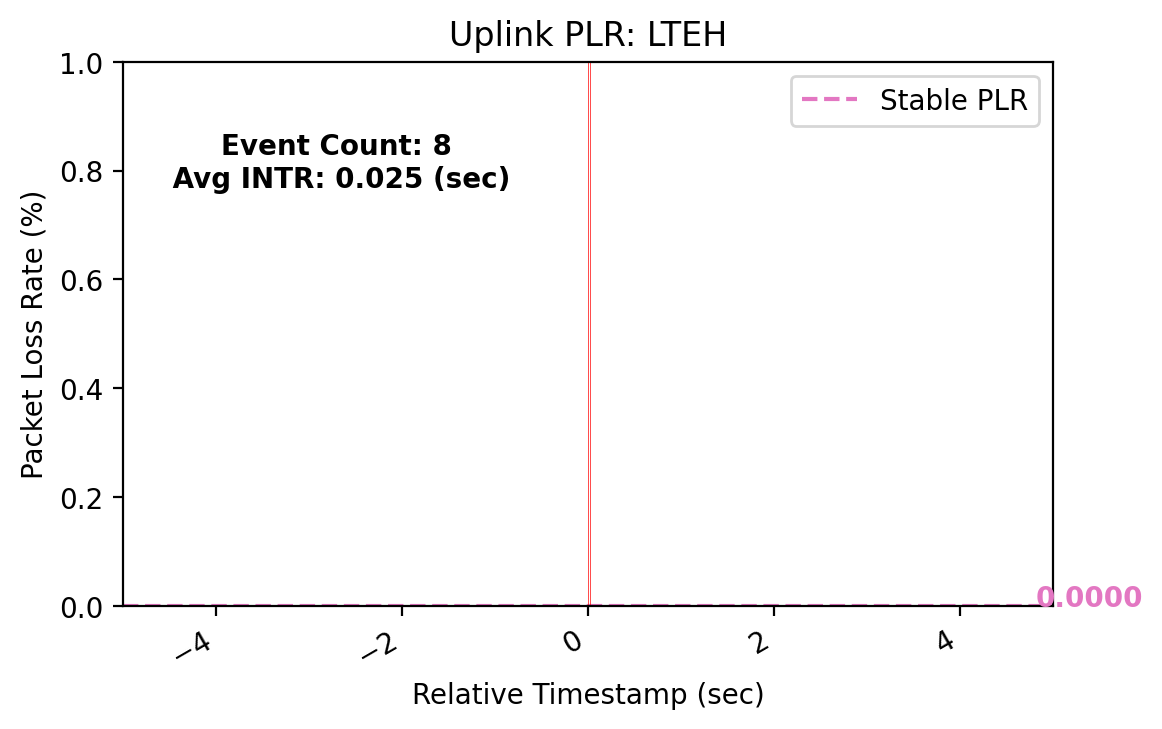

ENBH
Number of Event: 21
Average Duration: 0.023054190476190478 seconds
[(-0.1, 0.5)]
Uplink Stable PLR: 0.0
Uplink PLR (-0.1, 0.5) 4.585


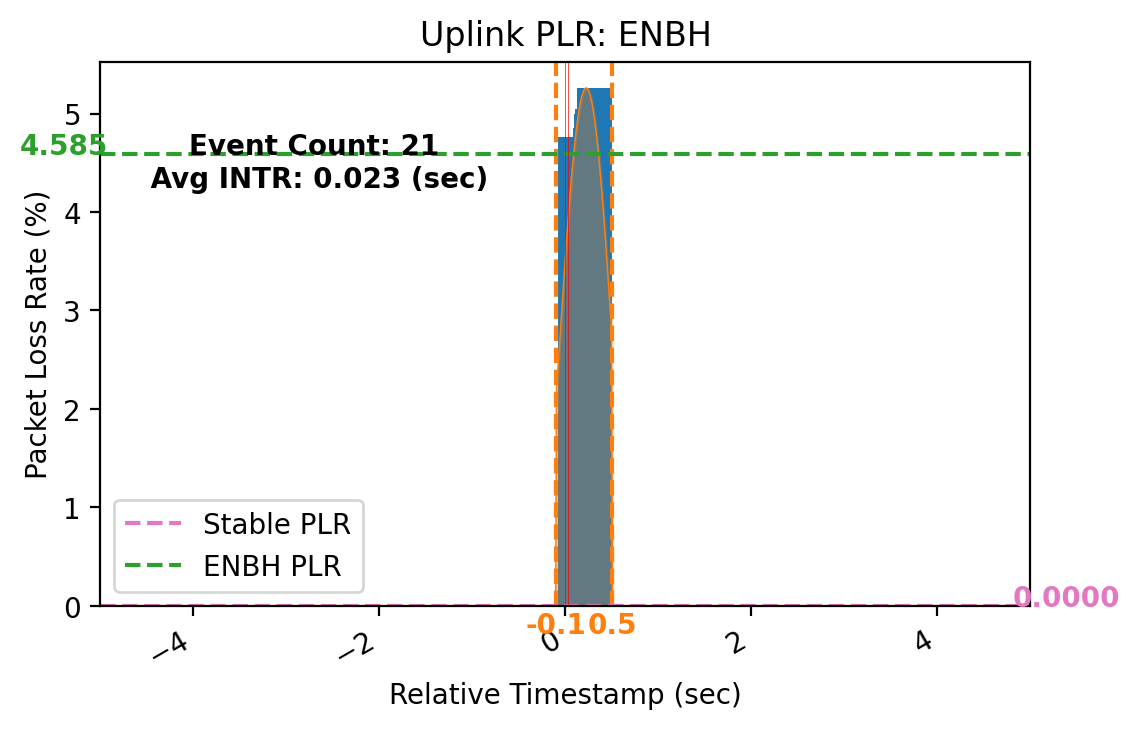

MCGH
Number of Event: 31
Average Duration: 0.01799535483870968 seconds
[(-0.5, 0.8)]
Uplink Stable PLR: 0.0
Uplink PLR (-0.5, 0.8) 4.621


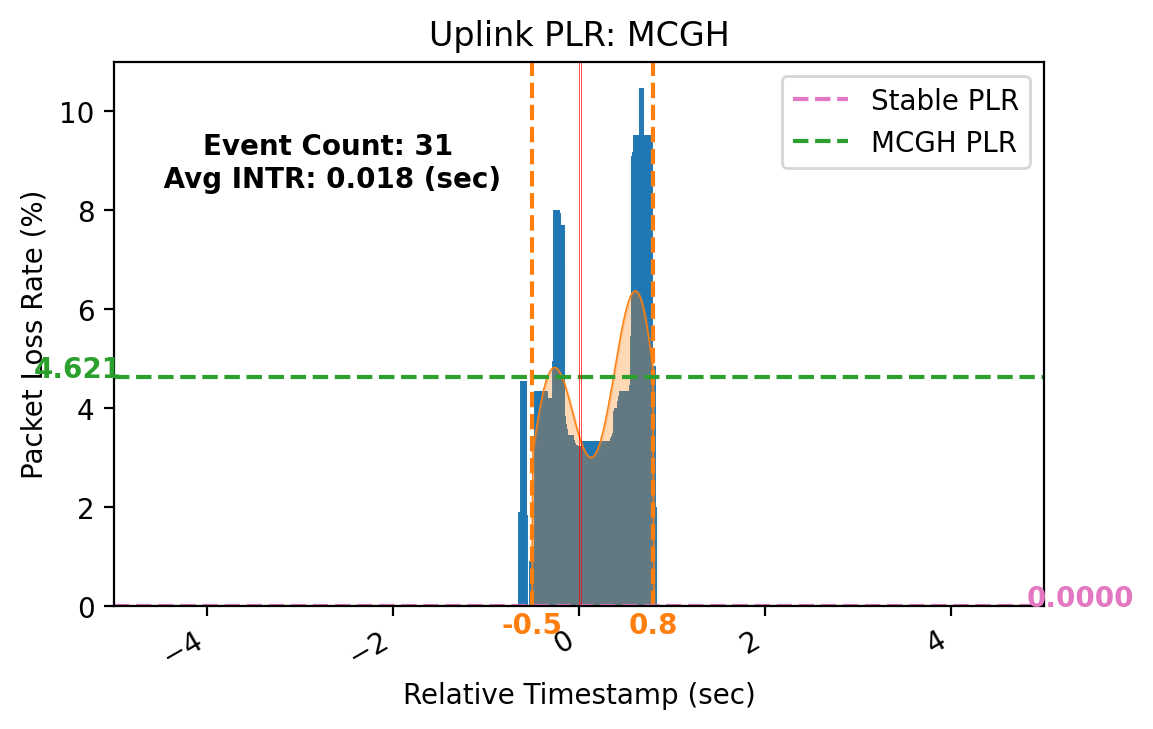

MNBH
Number of Event: 91
Average Duration: 0.019868076923076922 seconds
[(-0.5, 1.0)]
Uplink Stable PLR: 0.0
Uplink PLR (-0.5, 1.0) 3.418


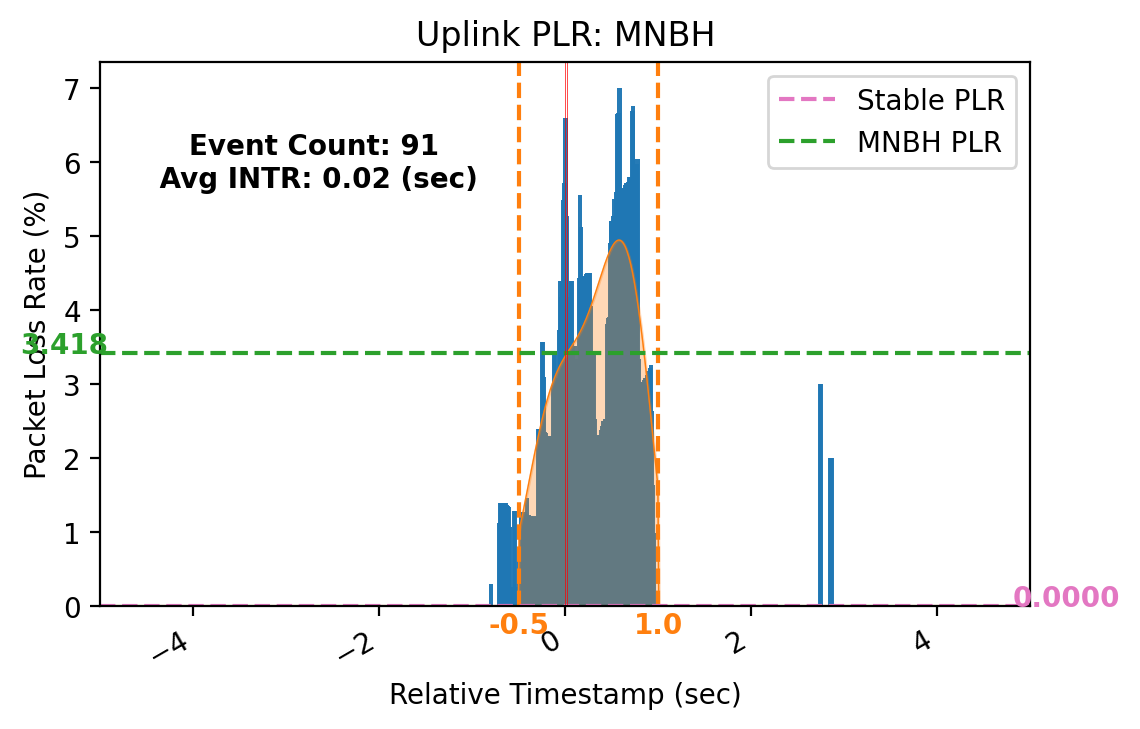

SCGA
Number of Event: 9
Average Duration: 0.02942822222222222 seconds
[(-0.1, 0.9)]
Uplink Stable PLR: 0.0
Uplink PLR (-0.1, 0.9) 0.708


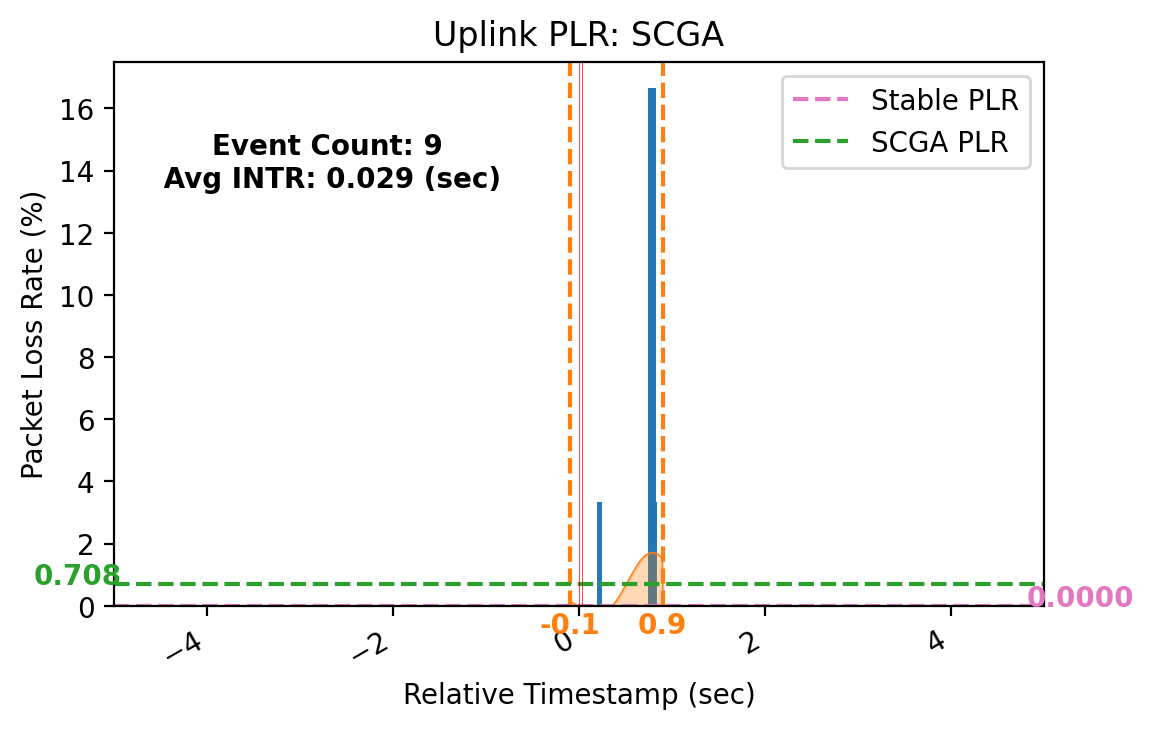

SCGM
Number of Event: 116
Average Duration: 0.01684015517241379 seconds
[(-0.6, 0.4)]
Uplink Stable PLR: 0.0
Uplink PLR (-0.6, 0.4) 1.28


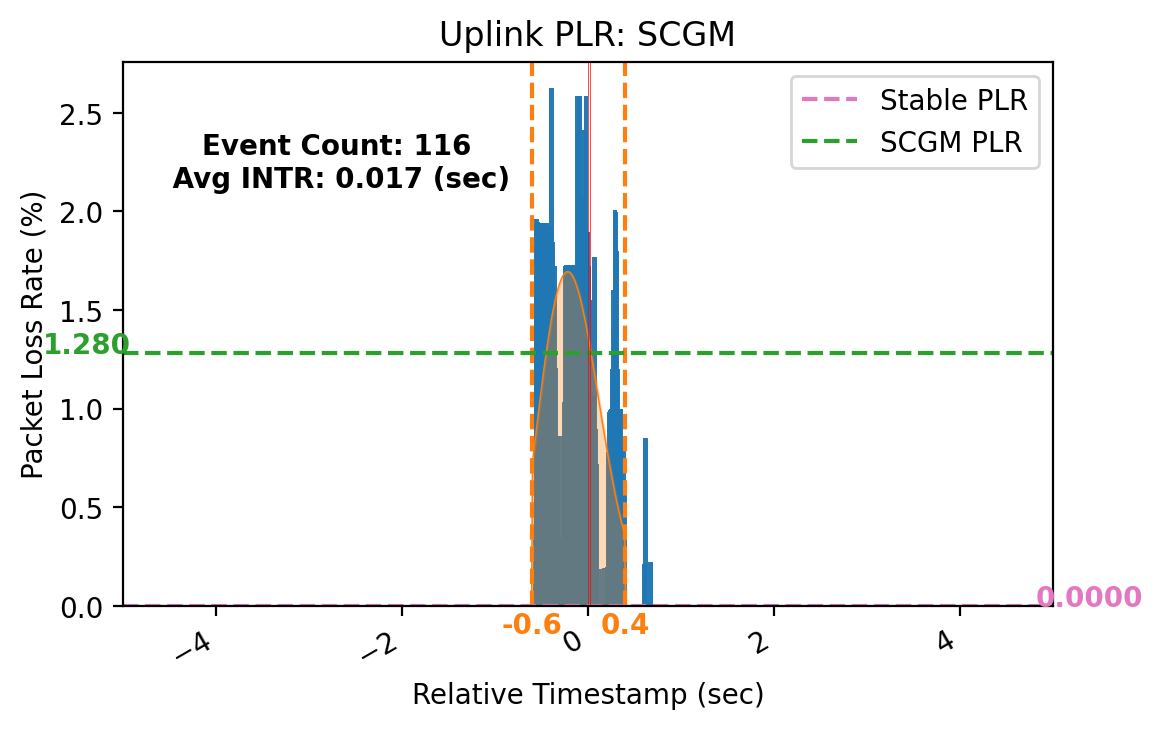

SCGR-I
Number of Event: 2
Average Duration: 0.0364925 seconds


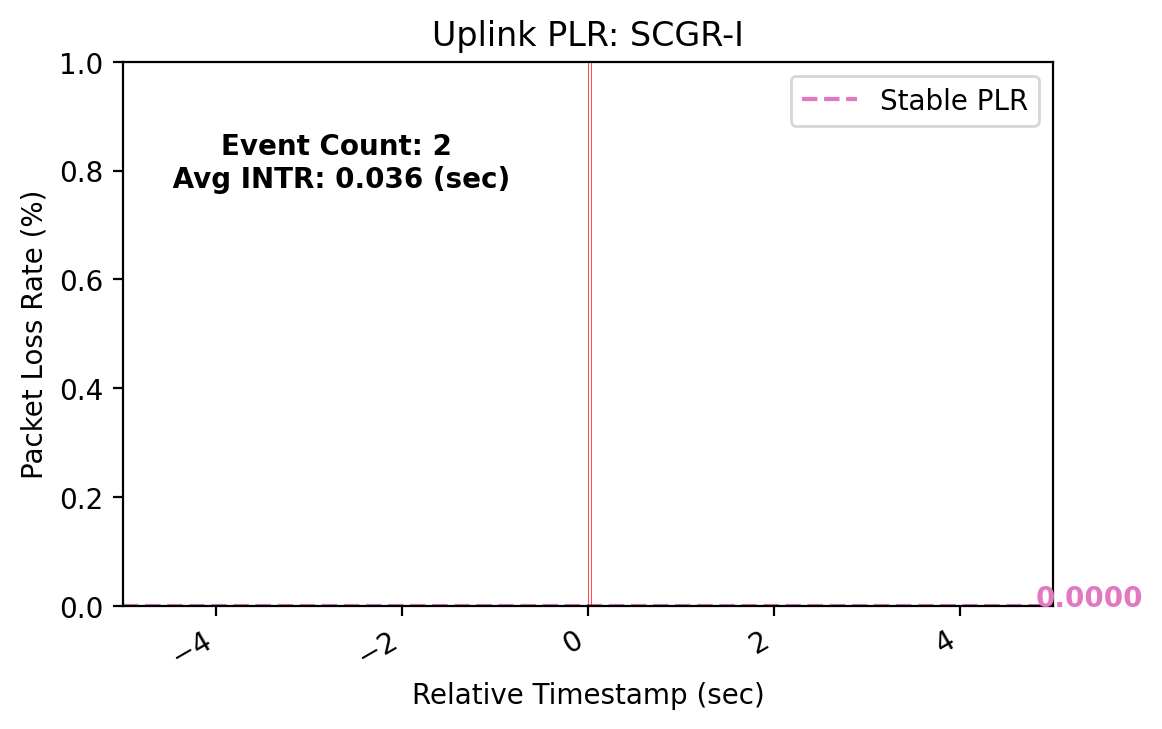

SCGR-II
Number of Event: 3
Average Duration: 0.035036 seconds


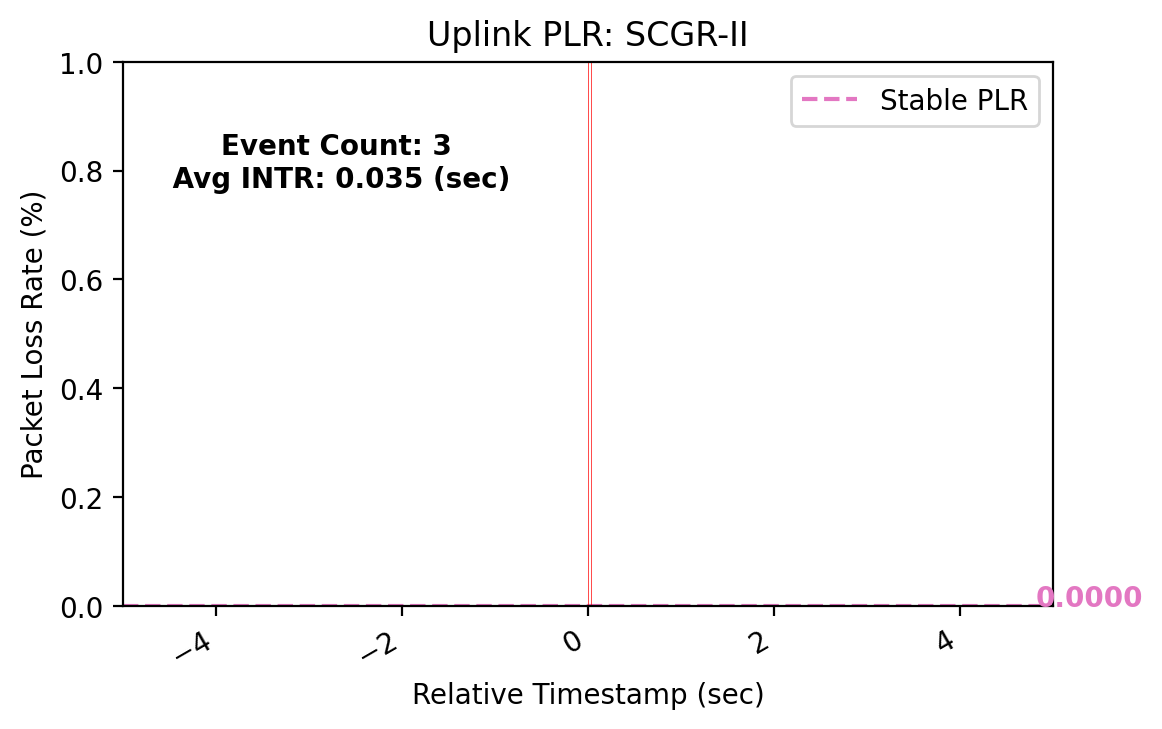

SCGC-I
Number of Event: 1
Average Duration: 0.434864 seconds
[(-2.7, 0.1)]
Uplink Stable PLR: 0.0
Uplink PLR (-2.7, 0.1) 3.571


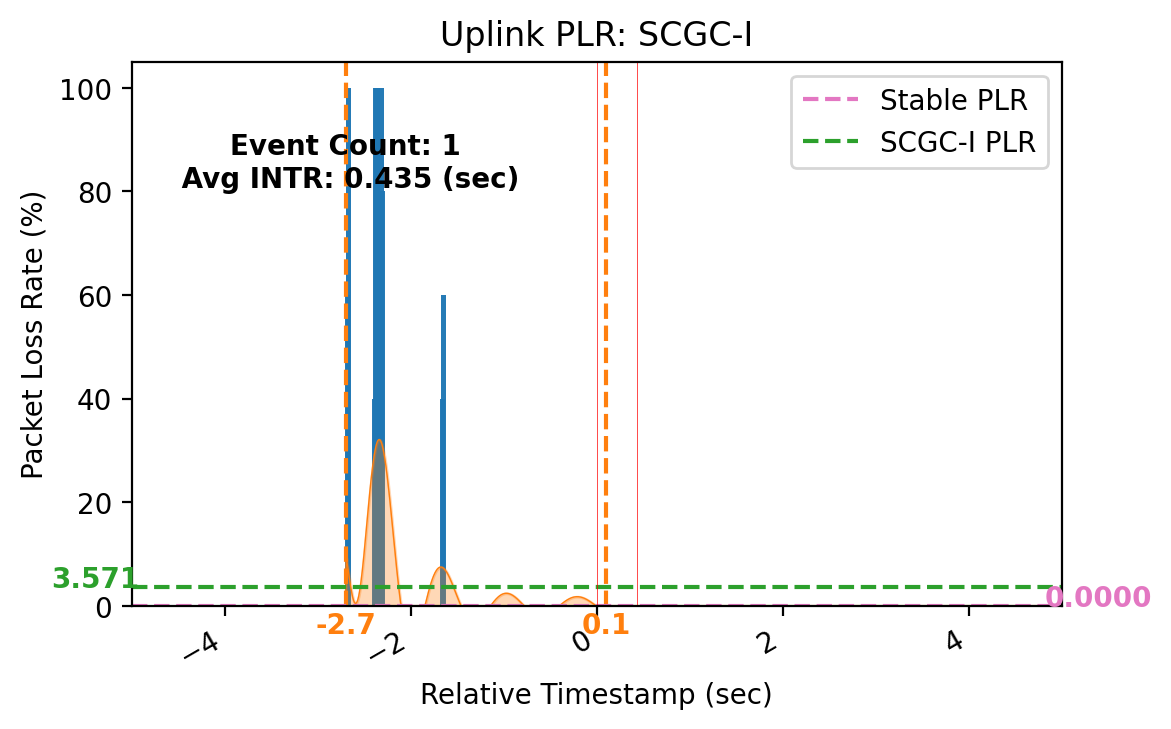

SCGC-II
Number of Event: 8
Average Duration: 0.463513 seconds
[(-0.1, 1.0)]
Uplink Stable PLR: 0.0
Uplink PLR (-0.1, 1.0) 1.054


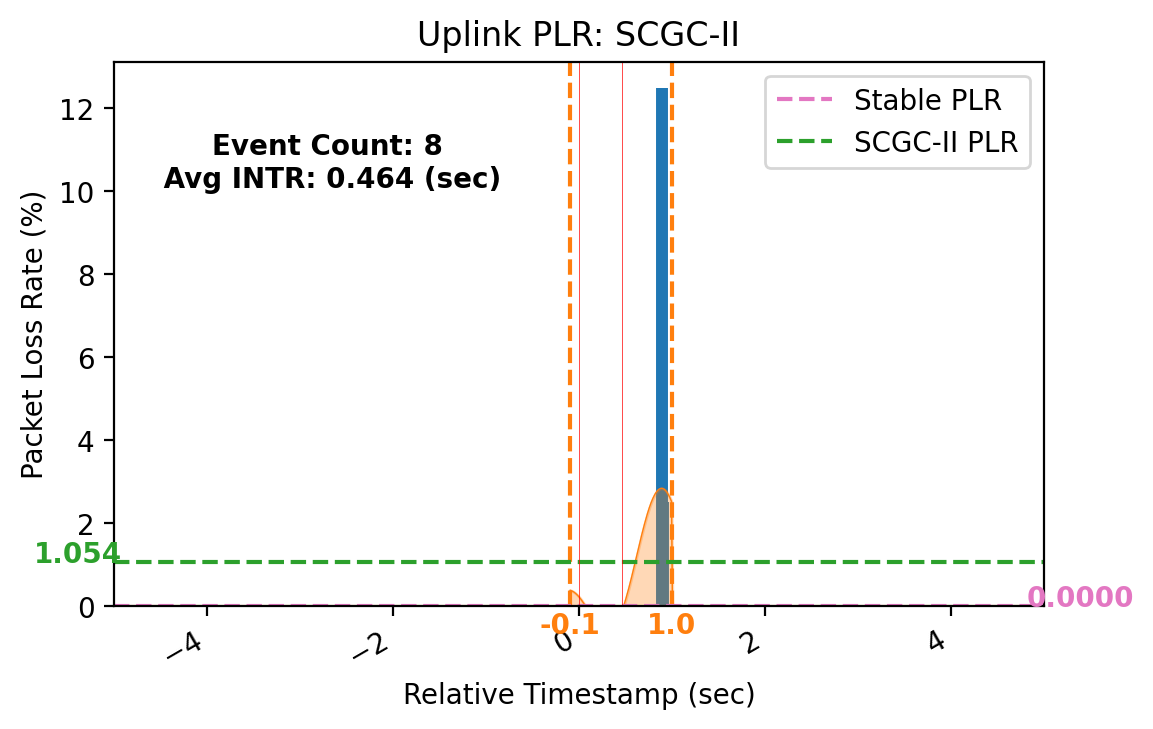

MCGF
Number of Event: 15
Average Duration: 0.08446086666666665 seconds
[(-5.4, 1.0)]
Uplink Stable PLR: 0.0
Uplink PLR (-5.4, 1.0) 28.127


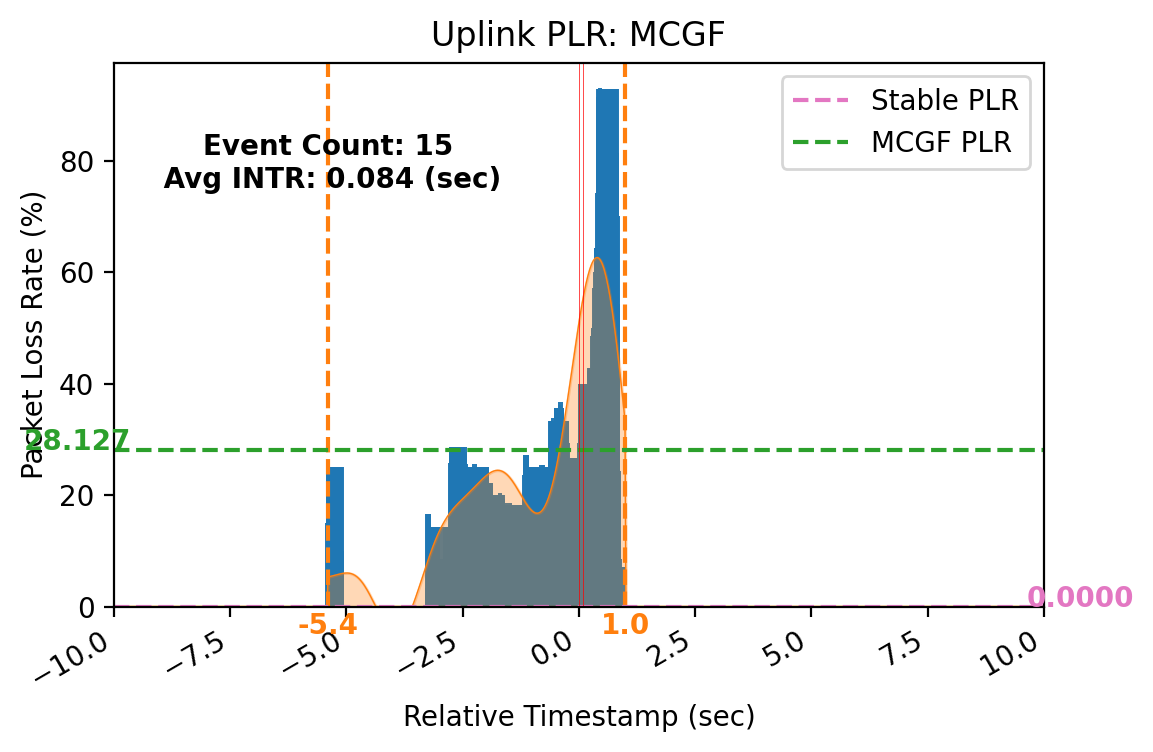

SCGF
Number of Event: 5
Average Duration: 0.0795852 seconds
[(-0.1, 0.7)]
Uplink Stable PLR: 0.0
Uplink PLR (-0.1, 0.7) 8.568


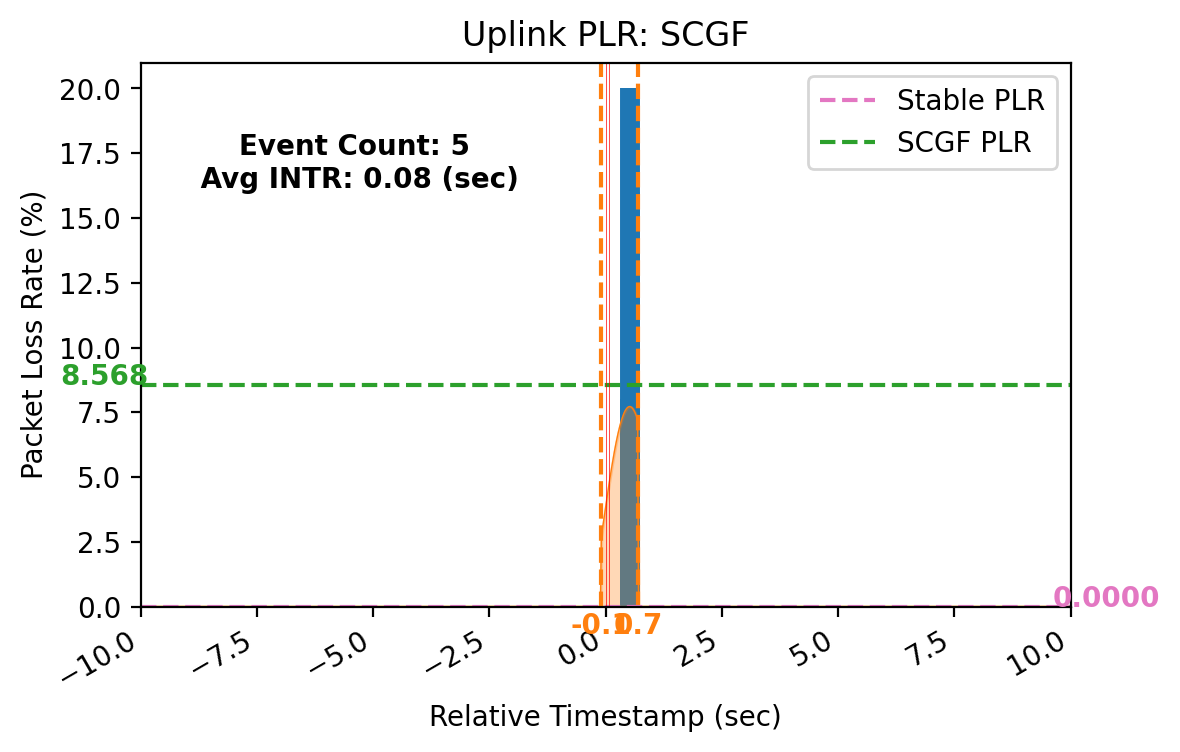

{'ul_lost': {'LTEH': (-5.0, 5.0),
             'ENBH': (-0.1, 0.5),
             'MCGH': (-0.5, 0.8),
             'MNBH': (-0.5, 1.0),
             'SCGA': (-0.1, 0.9),
             'SCGM': (-0.6, 0.4),
             'SCGR-I': (-5.0, 5.0),
             'SCGR-II': (-5.0, 5.0),
             'SCGC-I': (-2.7, 0.1),
             'SCGC-II': (-0.1, 1.0),
             'MCGF': (-5.4, 1.0),
             'NASR': (-10.0, 10.0),
             'SCGF': (-0.1, 0.7)}}


In [16]:
# # de-comment while not running the first time
# D = HOType_D.copy()
# E = HOType_E.copy()
# scope = { mets: {
#     tag: Category_scope[mets][category] for tag, category in lookup.items()
# } for mets in ['dl_lost', 'ul_lost', 'dl_excl', 'ul_excl'] }

# # *******************************************************************************************
D = HOType_D.copy()
E = HOType_E.copy()
scope = Initial_scope.copy()
# metrics=['dl_lost', 'dl_excl', 'ul_lost', 'ul_excl']
metrics=['ul_lost']

coef_tpl = pd.DataFrame(columns=['count', 'PLR/ELR', 'lower_bd', 'upper_bd', 'intr', *list(range(71))])
for tag in ['LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGA', 'SCGM', 'SCGR-I', 'SCGR-II', 'SCGC-I', 'SCGC-II']:
    coef_tpl.loc[tag] = [0, 0, -5, 5, 0, *np.zeros(71)]
for tag in ['MCGF', 'NASR', 'SCGF']:
    coef_tpl.loc[tag] = [0, 0, -10, 10, 0, *np.zeros(71)]
coef_tpl.loc['stable'] = ['-', 0, '-', '-', '-', *np.zeros(71)]
    
coef_df = {mets: coef_tpl.copy() for mets in metrics}

# coef_dl_lost = pd.DataFrame(columns=['lower_bd', 'upper_bd', *list(range(71))])
# coef_ul_lost = pd.DataFrame(columns=['lower_bd', 'upper_bd', *list(range(71))])
# coef_dl_excl = pd.DataFrame(columns=['lower_bd', 'upper_bd', *list(range(71))])
# coef_ul_excl = pd.DataFrame(columns=['lower_bd', 'upper_bd', *list(range(71))])

dist_df = {mets: {tag: None for tag in ['LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGA', 'SCGM', 'SCGR-I', 'SCGR-II', 'SCGC-I', 'SCGC-II', 'MCGF', 'NASR', 'SCGF']} for mets in metrics}

new_scope = { mets: {
    tag: scp for tag, scp in scope[mets].items()
} for mets in metrics }

for tag in scope[list(scope.keys())[0]].keys():
    if len(D[list(D.keys())[0]][tag]['intrs']) == 0:
            continue
    print('===========================================================================================')
    print(tag)
    
    for mm in metrics:
        mode = mm[:2]
        mets = mm[-4:]
        
        if mets == 'lost':
            stable_PLR = round(sum(E[f'{mode}_lost']['stable_miss']) / (sum(E[f'{mode}_lost']['stable_pkt']) + 1e-9) * 100, 4)
            coef_df[f'{mode}_{mets}'].loc['stable', 'PLR/ELR'] = stable_PLR
        elif mets == 'excl':
            stable_ELR = round(sum(E[f'{mode}_excl']['stable_miss']) / (sum(E[f'{mode}_excl']['stable_pkt']) + 1e-9) * 100, 4)
            coef_df[f'{mode}_{mets}'].loc['stable', 'PLR/ELR'] = stable_ELR
            
        table, intr = merge_profile(D[f'{mode}_{mets}'][tag]['tables'], D[f'{mode}_{mets}'][tag]['intrs'], mets=mets)
        
        print('Number of Event:', sum(D[f'{mode}_{mets}'][tag]['count']))
        print('Average Duration:', intr, 'seconds')
        
        if mets == 'lost':
            min_scope = approx_scope(table=table.copy(), mets=mets, evt_type=lookup[tag], stable_miss_rate=stable_PLR)
        elif mets == 'excl':
            min_scope = approx_scope(table=table.copy(), mets=mets, evt_type=lookup[tag], stable_miss_rate=stable_ELR)
        
        if min_scope != 0:
            new_scope[f'{mode}_{mets}'][tag] = min_scope
        
        # def plot_polynomial(scope, mode, mets, ):
        fig, ax = plt.subplots(figsize=(6, 4))
        
        # # *********************************************************
        # min_scope = HOType_scope[f'{mode}_{mets}'][tag]
        # new_scope[f'{mode}_{mets}'][tag] = min_scope
        # # *********************************************************
        
        left = scope[f'{mode}_{mets}'][tag][0]
        right = scope[f'{mode}_{mets}'][tag][1]
        bound = math.ceil(max(abs(right), abs(left)))
        left = -bound; right = bound
        ax.set_xlim(left, right)
        
        # width = 0.015 * (right - left)
        width = 0.005 * (right - left)
        if mets == 'lost':
            ax.bar(table['cat_id'], table['PLR'], width=width, alpha=0.97)
        elif mets == 'excl':
            ax.bar(table['cat_id'], table['ELR'], width=width, alpha=0.97)
            
        ax.set_ylim(0, max(1, ax.get_ylim()[1]))
        bottom, top = ax.get_ylim()

        if min_scope != 0:
            ax.axvline(min_scope[0], color='tab:orange', linestyle='--')
            ax.text(min_scope[0], bottom-0.05*(top-bottom), '{:.1f}'.format(min_scope[0]), ha='center', fontweight='bold', fontsize=10, color='tab:orange')
            ax.axvline(min_scope[1], color='tab:orange', linestyle='--')
            ax.text(min_scope[1], bottom-0.05*(top-bottom), '{:.1f}'.format(min_scope[1]), ha='center', fontweight='bold', fontsize=10, color='tab:orange')
            
            bleft = min_scope[0]
            bright = min_scope[1]
            
            x = np.asarray(table['cat_id'], dtype=np.float64)
            if mets == 'lost':
                y = np.asarray(table['PLR'], dtype=np.float64)
            elif mets == 'excl':
                y = np.asarray(table['ELR'], dtype=np.float64)
                
            with warnings.catch_warnings():
                warnings.simplefilter('ignore', np.RankWarning)
                z = np.polyfit(x, y, 70)
                p = np.poly1d(z)
            xp = np.linspace(table['cat_id'].iloc[0], table['cat_id'].iloc[-1], 1000)
            
            coef = p.coefficients
            
            ax.plot(xp, np.clip(p(xp)*np.vectorize(heaviside)(xp, bleft, bright), a_min=0, a_max=100), '-', c='tab:orange', lw=0.5)
            ax.fill_between(xp, np.clip(p(xp)*np.vectorize(heaviside)(xp, bleft, bright), a_min=0, a_max=100), color='tab:orange', alpha=0.3)
        
        if mets == 'lost':
            ax.axhline(stable_PLR, color='tab:pink', linestyle='--', label='Stable PLR')
            ax.text(1.078*right, stable_PLR, '{:.4f}'.format(stable_PLR), ha='center', fontweight='bold', fontsize=10, color='tab:pink')
            if min_scope != 0:
                _table = table[(table['cat_id'] >= min_scope[0]) & (table['cat_id'] < min_scope[1])].copy()
                PLR = round(sum(_table['lost']) / (sum(_table['tx_count']) + 1e-9) * 100, 3)
                if mode == 'dl':
                    print('Downlink Stable PLR:', stable_PLR)
                    print('Downlink PLR', min_scope, PLR)
                elif mode == 'ul':
                    print('Uplink Stable PLR:', stable_PLR)
                    print('Uplink PLR', min_scope, PLR)
                ax.axhline(PLR, color='tab:green', linestyle='--', label=f'{tag} PLR')
                ax.text(1.078*left, PLR, '{:.3f}'.format(PLR), ha='center', fontweight='bold', fontsize=10, color='tab:green')
        elif mets == 'excl':
            ax.axhline(stable_ELR, color='tab:pink', linestyle='--', label='Stable ELR')
            ax.text(1.078*right, stable_ELR, '{:.4f}'.format(stable_ELR), ha='center', fontweight='bold', fontsize=10, color='tab:pink')
            if min_scope != 0:
                _table = table[(table['cat_id'] >= min_scope[0]) & (table['cat_id'] < min_scope[1])].copy()
                ELR = round(sum(_table['excl']) / (sum(_table['tx_count']) + 1e-9) * 100, 3)
                if mode == 'dl':
                    print('Downlink Stable ELR:', stable_ELR)
                    print('Downlink ELR', min_scope, ELR)
                elif mode == 'ul':
                    print('Uplink Stable ELR:', stable_ELR)
                    print('Uplink ELR', min_scope, ELR)
                ax.axhline(ELR, color='tab:green', linestyle='--', label=f'{tag} ELR')
                ax.text(1.078*left, ELR, '{:.3f}'.format(ELR), ha='center', fontweight='bold', fontsize=10, color='tab:green')
                
        count = sum(D[f'{mode}_{mets}'][tag]['count'])
        intr = round(intr, 3)
        ax.axvline(0, color='red', alpha=1, linestyle='-', linewidth=0.25)
        ax.axvline(intr, color='red', alpha=1, linestyle='-', linewidth=0.25)
        ax.text(left+0.23*(right-left), bottom+0.77*(top-bottom), f'Event Count: {count}\n Avg INTR: {intr} (sec)', ha='center', fontweight='bold', fontsize=10)
        
        # ******************************************************************************************************************
        if min_scope != 0:
            if mets == 'lost':
                coef_df[f'{mode}_{mets}'].loc[tag] = [count, PLR, bleft, bright, intr, *list(coef)]
            elif mets == 'excl':
                coef_df[f'{mode}_{mets}'].loc[tag] = [count, ELR, bleft, bright, intr, *list(coef)]
            # display(table[(table['cat_id'] >= bleft) & (table['cat_id'] <= bright)])
            dist_df[f'{mode}_{mets}'][tag] = table[(table['cat_id'] >= bleft) & (table['cat_id'] <= bright)].reset_index(drop=True).copy()
        else:
            if mets == 'lost':
                coef_df[f'{mode}_{mets}'].loc[tag, ['count', 'intr']] = [count, intr]
            elif mets == 'excl':
                coef_df[f'{mode}_{mets}'].loc[tag, ['count', 'intr']] = [count, intr]
            # display(table)
            dist_df[f'{mode}_{mets}'][tag] = table.copy()
        # ******************************************************************************************************************
        
        if mode == 'dl':
            if mets == 'lost':
                ax.set_title(f'Downlink PLR: {tag}')
            elif mets == 'excl':
                ax.set_title(f'Downlink ELR: {tag}')
        elif mode == 'ul':
            if mets == 'lost':
                ax.set_title(f'Uplink PLR: {tag}')
            elif mets == 'excl':
                ax.set_title(f'Uplink ELR: {tag}')
        
        if mets == 'lost':
            ax.set_ylabel('Packet Loss Rate (%)')
        elif mets == 'excl':
            ax.set_ylabel('Excessive Latency Rate (%)')
        ax.set_xlabel('Relative Timestamp (sec)')
        ax.legend()
        
        plt.gcf().autofmt_xdate()
        plt.show()

pprint(new_scope, sort_dicts=False)

# HOType_D = D.copy()
# HOType_E = E.copy()
# HOType_scope = new_scope.copy()

## Evaluation

In [17]:
coef_dl_lost = coef_df['ul_lost'].copy()
dist_dl_lost = dist_df['ul_lost'].copy()
filepaths

[['/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm01/#01/data/handover_info_log.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm01/#01/data/udp_dnlk_loss_latency.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm01/#01/data/udp_uplk_loss_latency.csv']]

In [18]:
print(coef_dl_lost[['lower_bd', 'upper_bd', 'intr']])

        lower_bd upper_bd   intr
LTEH        -5.0      5.0  0.025
ENBH        -0.1      0.5  0.023
MCGH        -0.5      0.8  0.018
MNBH        -0.5      1.0   0.02
SCGA        -0.1      0.9  0.029
SCGM        -0.6      0.4  0.017
SCGR-I      -5.0      5.0  0.036
SCGR-II     -5.0      5.0  0.035
SCGC-I      -2.7      0.1  0.435
SCGC-II     -0.1      1.0  0.464
MCGF        -5.4      1.0  0.084
NASR       -10.0     10.0    0.0
SCGF        -0.1      0.7   0.08
stable         -        -      -


### Test 3

In [25]:
# scope = {
#     'LTEH':    (-5.0,  5.0,  0.025),
#     'ENBH':    (-0.1,  0.6,  0.023),
#     'MCGH':    (-0.3,  0.8,  0.018),
#     'MNBH':    (-0.6,  0.9,  0.02),
#     'SCGA':    (-0.1,  0.9,  0.029),
#     'SCGM':    (-1.0,  0.8,  0.017),
#     'SCGR-I':  (-5.0,  5.0,  0.036),
#     'SCGR-II': (-5.0,  5.0,  0.035),
#     'SCGC-I':  (-2.8,  0.1,  0.435),
#     'SCGC-II': (-0.1,  1.0,  0.464),
#     'MCGF':    (-4.3,  1.0,  0.084),
#     'NASR':    (-10.0, 10.0, 0.0),
#     'SCGF':    (-0.1,  0.8,  0.08),
# }

# scope = {
#     'LTEH':    (-5.0 , 5.0 , 0.025),
#     'ENBH':    (-0.1 , 0.5 , 0.023),
#     'MCGH':    (-0.5 , 0.8 , 0.018),
#     'MNBH':    (-0.5 , 1.0 , 0.02),
#     'SCGA':    (-0.1 , 0.9 , 0.029),
#     'SCGM':    (-0.6 , 0.4 , 0.017),
#     'SCGR-I':  (-5.0 , 5.0 , 0.036),
#     'SCGR-II': (-5.0 , 5.0 , 0.035),
#     'SCGC-I':  (-2.7 , 0.1 , 0.435),
#     'SCGC-II': (-0.1 , 1.0 , 0.464),
#     'MCGF':    (-5.4 , 1.0 , 0.084),
#     'NASR':    (-10.0, 10.0, 0.0),
#     'SCGF':    (-0.1 , 0.7 , 0.08),
# }

# df_ho = pd.read_csv(filepaths[0][0], parse_dates=['start', 'end'])
# df_dl = set_data(pd.read_csv(filepaths[0][1]))
# df_ul = set_data(pd.read_csv(filepaths[0][2]))
# E, _, df_dl = handover_classify_labelling(df_ho, df_dl=None, df_ul=df_dl, ratio=0.5, scope=scope)

Overlapping event occurs!!
221 2023-09-12 14:06:05.569537 2023-09-12 14:06:06.256488 MCGH nan
222 2023-09-12 14:06:06.013349 2023-09-12 14:06:06.193295 MCGF handoverFailure (1)


In [19]:
dl_filepath = os.path.join('./temp', '2023-01-10-udp_dnlk_loss_latency_ho_xmit_beta.pkl')
# df_dl.to_pickle(dl_filepath)

In [21]:
# random.seed(2023)

s = filepaths[0]
ho_df = pd.read_csv(s[0], parse_dates=['start'])[['type', 'start']]
dl_df = pd.read_pickle(dl_filepath)[['seq', 'lost', 'excl', 'xmit_time', 'arr_time', 'type']]

table_list = []
N = 10
for i in tqdm(range(N), ncols=1000):
    table = pd.DataFrame(columns=['Method 1', 'Method 2', 'Method 3', 'Ground Truth'])
    # display(table)

    for tag in ['LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGA', 'SCGM', 'SCGR-I', 'SCGR-II', 'SCGC-I', 'SCGC-II', 'MCGF', 'NASR', 'SCGF']:
    # for tag in ['ENBH', 'SCGM', 'SCGC-II']:
    # for tag in ['SCGC-II']:
        # print(tag)
        
        df = dl_df[dl_df['type'] == tag].reset_index(drop=True).copy()
        ho_df_copy = ho_df[ho_df['type'] == tag].reset_index(drop=True).copy()
        
        X = df['arr_time'].to_numpy()
        Yg = df['lost'].to_numpy()
        C = ho_df_copy['start'].to_numpy()
        T = ho_df_copy['type'].to_numpy()
        
        splr_gt = sum(Yg)/(len(Yg) + 1e-9) * 100
        
        ### Method 1
        
        Z = [(X - c) / np.timedelta64(1, 's') for c in C]
        
        Yp = []
        for i in range(len(C)):
            if T[i] not in coef_dl_lost.index.to_list():
                y = np.zeros(len(Z))
                continue
            y = poly_approx(coef_dl_lost.copy(), Z[i], T[i])
            Yp.append(y)
        
        Yp = [sum(s)/100 for s in zip(*Yp)]
        Y = np.array([generate_random_boolean(s) for s in Yp])
        
        splr_m1 = sum(Y)/(len(Y) + 1e-9) * 100
        
        ### Method 2, 3
        
        if len(X) != 0:
            
            # 只保留小數點後兩位(10ms)
            Ct = np.array([np.datetime_as_string(dt, unit='ms')[:-1] for dt in C], dtype='datetime64')
            plr_mapping = pd.DataFrame(columns=['cat_id', 'tx_count', 'lost', 'PLR'])
            for i, c in enumerate(Ct):
                tmp = dist_dl_lost[tag].copy()
                # if i == 0:
                #     print(len(tmp), tmp.tail(10))
                tmp['cat_id'] = pd.to_timedelta(tmp['cat_id'], unit='s') + c
                plr_mapping = pd.concat([plr_mapping, tmp], axis=0).reset_index(drop=True)
                # print(len(tmp), tmp)
            # print(len(plr_mapping), plr_mapping)
            
            plr_mapping = plr_mapping.groupby('cat_id').agg({'tx_count': 'sum', 'lost': 'sum'}).reset_index()
            plr_mapping['PLR'] = (plr_mapping['lost'] / plr_mapping['tx_count'])
            plr_mapping = plr_mapping[['cat_id', 'PLR']]
            
            # *******************************************************************************************
            # Xt = np.array([np.datetime_as_string(dt, unit='ms')[:-1] for dt in X], dtype='datetime64')
            Xt = np.array([np.datetime_as_string(dt, unit='ms')[:-1] for dt in X + np.timedelta64(5, 'ms')], dtype='datetime64')
            # *******************************************************************************************
            answer = pd.DataFrame({'X': X, 'Xt': Xt, 'Yg': Yg})
            answer = pd.merge(answer, plr_mapping, left_on='Xt', right_on='cat_id', how='left')
            answer['PLR'] = answer['PLR'].fillna(0)
            answer['Y'] = answer['PLR'].apply(generate_random_boolean)
            
            Y = answer['Y'].to_numpy()
            splr_m2 = answer['Y'].mean() * 100
            splr_m3 = answer['PLR'].mean() * 100
        else:
            Y = []
            splr_m2 = 0.0    
            splr_m3 = 0.0

        table.loc[tag] = [splr_m1, splr_m2, splr_m3, splr_gt]
        
        # if tag == 'SCGC-II':
            
        #     fig, (ax, ax_twin) = plt.subplots(2, 1, figsize=(6, 4))
            
        #     x1 = [ts for ts, lo in zip(X, Y) if lo]
        #     ax.vlines(x1 ,ymin=0, ymax=0.4, label='eval', color='tab:blue', alpha=0.5)
        #     x2 = [ts for ts, lo in zip(X, Yg) if lo]
        #     ax.vlines(x2 ,ymin=0.6, ymax=1, label='ground', color='tab:red', alpha=0.5)
        #     ax.set_ylim(0, 1)
            
        #     ax.scatter(C, [0.5]*len(C), marker='D', s=14, label=tag, alpha=0.75, color='tab:orange')
            
        #     print(x1)
        #     print(x2)
            
        #     fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0), fancybox=True, ncol=4)
        #     fig.suptitle(tag)
            
        #     # 創建 DataFrame
        #     df = pd.DataFrame({'Timestamp': X, 'PacketLoss': Yg})
        #     # 將 Timestamp 設定為 DataFrame 的 index
        #     df.set_index('Timestamp', inplace=True)
        #     # 使用 resample 以秒為單位計算每秒的 loss rate
        #     loss_rate = df.resample('S').mean() * 100
        #     # 填充缺失的值，以便將 NaN 轉換為 0
        #     loss_rate['PacketLoss'].fillna(0, inplace=True)
            
        #     # 繪製折線圖，僅標記 loss rate 大於 0 的點
        #     ax_twin.plot(loss_rate.index, loss_rate['PacketLoss'], marker=None, linestyle='-', color='tab:red', alpha=0.75)
        #     ax_twin.scatter(loss_rate[loss_rate['PacketLoss'] > 0].index, loss_rate['PacketLoss'][loss_rate['PacketLoss'] > 0], color='tab:red', marker='o', alpha=0.75, s=14)
        #     # ax_twin.set_ylim(bottom=0)
            
        #     # 創建 DataFrame
        #     df = pd.DataFrame({'Timestamp': X, 'PacketLoss': Y})
        #     # 將 Timestamp 設定為 DataFrame 的 index
        #     df.set_index('Timestamp', inplace=True)
        #     # 使用 resample 以秒為單位計算每秒的 loss rate
        #     loss_rate = df.resample('S').mean() * 100
        #     # 填充缺失的值，以便將 NaN 轉換為 0
        #     loss_rate['PacketLoss'].fillna(0, inplace=True)
            
        #     # 繪製折線圖，僅標記 loss rate 大於 0 的點
        #     ax_twin.plot(loss_rate.index, loss_rate['PacketLoss'], marker=None, linestyle='-', color='tab:blue', alpha=0.75)
        #     ax_twin.scatter(loss_rate[loss_rate['PacketLoss'] > 0].index, loss_rate['PacketLoss'][loss_rate['PacketLoss'] > 0], color='tab:blue', marker='o', alpha=0.75, s=14)
        #     ax_twin.set_ylim(bottom=0)
            
        #     ax_twin.set_ylabel('Packet Loss Rate\n(in each second)')
            
        #     ax_twin.set_ylim(top=ax_twin.get_ylim()[1]*1.15)
            
        #     plt.gcf().autofmt_xdate()
        #     plt.tight_layout()
        #     plt.show()
        
        # print('Method 1', '|', 'Method 2', '|', 'Method 3', '|', 'Ground Truth')
        # print(splr_m1, '|', splr_m2, '|', splr_m3, '|', splr_gt)
        # print('-------')
    
    table_list.append(table.copy())

# Assuming df1, df2, and df3 are your three dataframes
keys = ['Run {}'.format(i+1) for i in range(N)]

# Concatenate the dataframes along a new axis (assuming they have the same structure)
concatenated_df = pd.concat(table_list, keys=keys, axis=0)

# Get the original index order
index_order = table_list[0].index

# Calculate average table with original index order
average_table = concatenated_df.groupby(level=1).mean().reindex(index_order)

# Calculate standard deviation table with original index order
std_dev_table = concatenated_df.groupby(level=1).std().reindex(index_order)

# Print the results
print("Average Table:")
print(average_table)
print("\nStandard Deviation Table:")
print(std_dev_table)

  0%|                                                                                                         …

Average Table:
          Method 1   Method 2   Method 3  Ground Truth
LTEH      0.000000   0.000000   0.000000      0.000000
ENBH      4.138343   4.452605   4.484885      4.133219
MCGH      4.224035   4.374702   4.359519      4.406860
MNBH      3.539091   3.335596   3.339483      3.900176
SCGA      0.694874   0.034400   0.043573      0.756794
SCGM      1.192607   1.288901   1.281315      0.871692
SCGR-I    0.000000   0.000000   0.000000      0.000000
SCGR-II   0.000000   0.000000   0.000000      0.000000
SCGC-I    3.271684   1.307398   1.326531      3.188776
SCGC-II   0.823639   1.293625   1.283737      1.070265
MCGF     24.386062  22.705315  22.729462     22.579841
NASR      0.000000   0.000000   0.000000      0.000000
SCGF      6.440232   8.141127   8.619273      8.794102

Standard Deviation Table:
         Method 1  Method 2  Method 3  Ground Truth
LTEH     0.000000  0.000000       0.0           0.0
ENBH     0.217244  0.221675       0.0           0.0
MCGH     0.120586  0.115517     

In [34]:
print(len(X), X)
print(len(Xt), Xt)

1899 ['2023-09-12T13:46:45.114229443' '2023-09-12T13:46:45.120048443'
 '2023-09-12T13:46:45.120048443' ... '2023-09-12T14:15:01.537779443'
 '2023-09-12T14:15:01.537779443' '2023-09-12T14:15:01.537779443']
1899 ['2023-09-12T13:46:45.110' '2023-09-12T13:46:45.120'
 '2023-09-12T13:46:45.120' ... '2023-09-12T14:15:01.530'
 '2023-09-12T14:15:01.530' '2023-09-12T14:15:01.530']


In [35]:
# Assuming avg_table and std_dev_table are your Average and Standard Deviation tables

# Concatenate the tables along a new axis with a MultiIndex for columns
overall_df = pd.concat([average_table, std_dev_table], axis=1, keys=['Avg', 'Std'])

# Swap the levels of the MultiIndex columns
# overall_df = overall_df.swaplevel(axis=1)

# Print the concatenated dataframe
print(overall_df)

overall_df.to_csv("./temp/2024-01-15-test_eval_ground_xmit_beta.csv")

               Avg                                          Std            \
          Method 1   Method 2   Method 3 Ground Truth  Method 1  Method 2   
LTEH      0.000000   0.000000   0.000000     0.000000  0.000000  0.000000   
ENBH      4.057797   4.484646   4.463114     4.133219  0.249201  0.270936   
MCGH      4.207861   4.343556   4.356859     4.406860  0.154655  0.157085   
MNBH      3.552525   3.332519   3.331222     3.900176  0.079862  0.069081   
SCGA      0.621878   0.032267   0.032106     0.756794  0.138252  0.031222   
SCGM      1.193543   1.282230   1.282723     0.871692  0.048113  0.049235   
SCGR-I    0.000000   0.000000   0.000000     0.000000  0.000000  0.000000   
SCGR-II   0.000000   0.000000   0.000000     0.000000  0.000000  0.000000   
SCGC-I    3.229719   1.188648   1.186224     3.188776  0.414837  0.110701   
SCGC-II   0.860540   1.488320   1.487901     1.070265  0.134788  0.175079   
MCGF     24.360917  22.753090  22.756243    22.579841  0.193556  0.178145   